In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import Lasso
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# **Loading Data**

In [2]:
def extract_last_name(full_name):
    name_parts = full_name.split(' ')
    if len(name_parts) > 1:
        return ' '.join(name_parts[1:])
    return full_name

def extract_first_name(full_name):
    name_parts = full_name.split(' ')
    return ' '.join(name_parts[:1])


In [3]:
def pre_process_fifa (df):
    df['last_name'] = df['short_name'].apply(extract_last_name)
    df['first_name'] = df['long_name'].apply(extract_first_name)
    df['name'] = df['first_name'] + ' ' + df['last_name']
    standard_columns = {
          'nationality': 'nationality_name',
          'club': 'club_name',
          'defending_marking': 'defending_marking_awareness',
          'gk_diving': 'goalkeeping_diving',
          'gk_handling': 'goalkeeping_handling',
          'gk_kicking': 'goalkeeping_kicking',
          'gk_reflexes': 'goalkeeping_reflexes',
          'gk_speed': 'goalkeeping_speed',
          'gk_positioning': 'goalkeeping_positioning',
          'team_position': 'club_position',
          'team_jersey_number': 'club_jersey_number',
          'loaned_from': 'club_loaned_from',
          'joined': 'club_joined',
          'contract_valid_until': 'club_contract_valid_until',
          'age' : 'fifa_age'
      }

    df.rename(columns=standard_columns, inplace=True)

    columns_to_drop = ['player_url', 'dob', 'club_jersey_number', 'club_loaned_from', 'league_id' , 'fifa_age'
                       'body_type', 'nation_jersey_number', 'real_face', 'last_name',	'first_name',
                       'club_contract_valid_until', 'club_logo_url', 'club_flag_url', 'club_team_id', 'nationality_id', 
                      'player_id',  'fifa_update', 'update_as_of', 'short_name', 'long_name', 'club_team_id', 'club_joined_date', 'nation_team_id',
                     
                       'nation_logo_url', 'nation_flag_url', 'league_name', 'sofifa_id', 'player_face_url'] #TODO INCLUDED BEFORE 'check fifa age and club contract
    columns_existing_to_drop = [col for col in columns_to_drop if col in df.columns]
    df = df.drop(columns=columns_existing_to_drop)
    return df


### Notice that you have to change the path to the data according to your PC

In [4]:
df_24 = pd.read_csv('/Users/yardennahum/Desktop/Fintech Project/Data/Fifa_24.csv') # Define correct path to data
df_24 = df_24[df_24['fifa_version'] >= 15] # taking data from 2015 to 2024
df_24 = pre_process_fifa (df_24)

/var/folders/6_/dhlq5ftj4c76n7p9cz2cjkyw0000gn/T/ipykernel_30346/2837656122.py:1: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_24 = pd.read_csv('/Users/yardennahum/Desktop/Fintech Project/Data/Fifa_24.csv') # Define correct path to data


In [5]:
full_joined_df = pd.DataFrame(columns = df_24.columns.tolist())
for i in range (8):
    # take current year stats
    df_fifa_current_year = df_24[df_24['fifa_version'] == (24 - i - 2)] 

    # take markt 1 year after
    df_fifa_pre_year = df_24[df_24['fifa_version'] ==(24 - i - 1)][['value_eur', 'name']] 
    df_fifa_pre_year = df_fifa_pre_year.rename(columns={'value_eur': 'value_eur_1_year'})

    # players stats 2 years after
    df_fifa_pre_pre_year = df_24[df_24['fifa_version'] ==(24 - i )][['value_eur', 'name']] 
    df_fifa_pre_pre_year = df_fifa_pre_pre_year.rename(columns={'value_eur': 'value_eur_2_year'})

    fifa_one_year_ago_now = pd.merge(df_fifa_current_year, df_fifa_pre_year, on='name', how='inner')
    fifa_one_year_ago_now = fifa_one_year_ago_now.drop_duplicates(subset=['name'])


    fifa_two_year_ago_now =  pd.merge(fifa_one_year_ago_now,df_fifa_pre_pre_year, on='name', how='inner')
    fifa_two_year_ago_now = fifa_two_year_ago_now.drop_duplicates(subset=['name'])

    dfs_to_merge = [full_joined_df, fifa_two_year_ago_now]
    full_joined_df = pd.concat(dfs_to_merge, ignore_index=True)
    print("iteration", i, full_joined_df['fifa_version'].unique())

full_joined_df.to_csv('merged_data.csv', index=False)

len(full_joined_df)

/var/folders/6_/dhlq5ftj4c76n7p9cz2cjkyw0000gn/T/ipykernel_30346/2036026594.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_joined_df = pd.concat(dfs_to_merge, ignore_index=True)


iteration 0 [22.]
iteration 1 [22. 21.]
iteration 2 [22. 21. 20.]
iteration 3 [22. 21. 20. 19.]
iteration 4 [22. 21. 20. 19. 18.]
iteration 5 [22. 21. 20. 19. 18. 17.]
iteration 6 [22. 21. 20. 19. 18. 17. 16.]
iteration 7 [22. 21. 20. 19. 18. 17. 16. 15.]


77827

In [6]:
positions = ['LW', 'RF', 'RS', 'ST', 'SUB', 'LCB', 'RW', 'GK', 'RDM', 'LM',
             'RCM', 'RCB', 'RB', 'LCM', 'LDM', 'RES', 'LB', 'LS', 'CAM', 'CDM',
             'RM', 'CM', 'CF', 'CB', 'LF', 'LAM', 'LWB', None, 'RWB', 'RAM']

# Define a mapping dictionary for different positions
position_mapping = {
    'GK': 1,  # Goalkeeper
    'LCB': 2, 'RCB': 2, 'CB': 2, 'RB': 3, 'LB': 3, 'RWB': 3, 'LWB': 3,  # Defense
    'CDM': 4, 'LDM': 4, 'RDM': 4, 'CM': 4, 'LCM': 4, 'RCM': 4, 
    'CAM': 5, 'LAM': 5, 'RAM': 5, 'LM': 5, 'RM': 5,  # Midfield
    'LW': 5, 'RW': 5, 'LF': 6, 'RF': 6, 'LS': 6, 'RS': 6, 'ST': 6, 'CF': 6  # Attack
}

# Convert positions to numbers while keeping only values present in the mapping
full_joined_df['position'] = full_joined_df['club_position'].map(position_mapping)

# Remove irrelevant positions (those not in the mapping dictionary)
full_joined_df = full_joined_df.dropna(subset=['position'])


### Printing how many players from each position

In [7]:
pos_list = ['','GK', 'CB', 'RB', 'DEFENCIVE MID', 'ATTACKING MID', 'STRIKER']
for i in range(1,7):
    print(f"number of players in position {pos_list[i]}:", len(full_joined_df[full_joined_df['position'] == i]))
print(f"\nTotal number of players in the data: {len(full_joined_df)}")

number of players in position GK: 3662
number of players in position CB: 7091
number of players in position RB: 6474
number of players in position DEFENCIVE MID: 7871
number of players in position ATTACKING MID: 7821
number of players in position STRIKER: 4427

Total number of players in the data: 37346


__player_traits and player_tags represent special skills so we will count them for each player__

In [8]:
# player tags represent the player skills
print(f"Player tags:{full_joined_df['player_tags'].unique()[0]}")
print(f"Player traits: {full_joined_df['player_traits'].unique()[0]}")

Player tags:#Dribbler, #Distance Shooter, #FK Specialist, #Acrobat, #Clinical Finisher, #Complete Forward
Player traits: Finesse Shot, Long Shot Taker (AI), Playmaker (AI), Outside Foot Shot, One Club Player, Chip Shot (AI), Technical Dribbler (AI)


In [9]:
#if the player didnt have skill is appear as nan so then we will define it as 0
#the skills separate by , so we will split them and then count
full_joined_df['player_tags'] = full_joined_df['player_tags'].apply(lambda x: len(set(x.split(','))) if isinstance(x, str) else 0)
full_joined_df['player_traits'] = full_joined_df['player_traits'].apply(lambda x: len(set(x.split(','))) if isinstance(x, str) else 0)

In [10]:
full_joined_df['player_tags'].unique()
full_joined_df['player_traits'].unique()
# We counted how many traits and skills every player has.

array([7, 4, 2, 5, 6, 3, 1, 0, 8])

## Rating clubs
__In order to help our model, we gave a grade between 1 to 5 for every club, according to FIFA.__

In [11]:
# rate each team 
team_ratings = {    # דירוג 1 (הכי טוב)
 # דירוג 1 (הכי טוב)
    'FC Barcelona': 1,
    'Inter': 1,
    'Atlético Madrid': 1,
    'Chelsea': 1,
    'Liverpool': 1,
    'Manchester United': 1,
    'Manchester City': 1,
    'Real Madrid': 1,
    'Juventus': 1,
    'Paris Saint Germain': 1,
    'FC Bayern München': 1,
    'Arsenal': 1,
    'Tottenham Hotspur': 1,
    
    # דירוג 2
    'AC Milan': 2,
    'Borussia Dortmund': 2,
    'Roma': 2,
    'Napoli': 2,
    'Lazio': 2,
    'Olympique de Marseille': 2,
    'Ajax': 2,
    'Benfica': 2,
    'Porto': 2,
    'Sporting CP': 2,
    'Sevilla': 2,
    'Real Betis': 2,
    'Real Sociedad': 2,
    'Villarreal': 2,
    'Atalanta': 2,
    'Everton': 2,
    'Newcastle United': 2,
    'Valencia': 2,
    'West Ham United': 2,
    
    # דירוג 3
    'Lille': 3,
    'Lyon': 3,
    'Nice': 3,
    'Monaco': 3,
    'Eintracht Frankfurt': 3,
    'Bayer 04 Leverkusen': 3,
    'RB Leipzig': 3,
    'Wolfsburg': 3,
    'Borussia Mönchengladbach': 3,
    'Feyenoord': 3,
    'PSV': 3,
    'Club Brugge': 3,
    'Celtic': 3,
    'Rangers': 3,
    'Zenit St. Petersburg': 3,
    'Athletic Club': 3,
    'Wolverhampton Wanderers': 3,
    'Leicester City': 3,
    'Brighton & Hove Albion': 3,
    'Fiorentina': 3,
    'Crystal Palace': 3,
    'Hertha BSC': 3,
    'Basel': 3,
    'Rennes': 3,
    'FC Utrecht': 3,
    'Parma': 3,
    'Spartak Moskva': 3,
    'Beşiktaş': 3,
    'Olympiakos Piraeus': 3,
    'Burnley': 3,
    'İstanbul Başakşehir': 3,
    'Fulham': 3,
    'River Plate': 3,
    'Saint-Étienne': 3,
    'Shakhtar Donetsk': 3,
    'CSKA Moskva': 3,
    'Dinamo Zagreb': 3,
    'AZ Alkmaar': 3,
    
    # דירוג 4
    'Anderlecht': 4,
    'FSV Mainz 05': 4,
    'Olympique Lyonnais': 4,
    'Lens': 4,
    'Genoa': 4,
    'Almería': 4,
    'SC Freiburg': 4,
    'Torino': 4,
    'FC Union Berlin': 4,
    'Montpellier': 4,
    'Leeds United': 4,
    'Sassuolo': 4,
    'Udinese': 4,
    'Trabzonspor': 4,
    'FC Köln': 4,
    'Norwich City': 4,
    'AFC Bournemouth': 4,
    'Toulouse': 4,
    'Schalke 04': 4,
    'Aston Villa': 4,
    'Hellas Verona': 4,
    'Bologna': 4,
    'Real Valladolid': 4,
    'Getafe': 4,
    'Osasuna': 4,
    'Rayo Vallecano': 4,
    'Granada': 4,
    'Sheffield Wednesday': 4,
    'Sampdoria': 4,
    'Espanyol': 4,
    'Mallorca': 4,
    'Strasbourg': 4,
    'Southampton': 4,
    'Nantes': 4,
    'Brøndby': 4,
    'Darmstadt 98': 4,
    'Bordeaux': 4,
    'Coventry City': 4,
    'Dijon': 4,
    'SPAL': 4,
    'Salzburg': 4,
    'Sheffield United': 4,
    'Midtjylland': 4,
    'Talleres Córdoba': 4,
    'Cagliari': 4,
    'Huesca': 4,
    'West Bromwich Albion': 4,
    
    # דירוג 5
    'Como': 5,
    'Salernitana': 5,
    'Cádiz': 5,
    'Las Palmas': 5,
    'Abha': 5,
    'Adana Demirspor': 5,
    'FC Augsburg': 5,
    'VfL Bochum 1848': 5,
    'RWDM': 5,
    'Hatayspor': 5,
    'AEK Athens': 5,
    'Osnabrück': 5,
    'Bastia': 5,
    'Al Fayha': 5,
    'Cercle Brugge': 5,
    'Laval': 5,
    'Frosinone': 5,
    'Swansea City': 5,
    'Ternana': 5,
    'Fatih Karagümrük': 5,
    'Metz': 5,
    'Troyes': 5,
    'Chicago Fire': 5,
    'Mirandés': 5,
    'Burton Albion': 5,
    'Preston North End': 5,
    'Watford': 5,
    'Atlanta United': 5,
    'Brentford': 5,
    'Empoli': 5,
    'Stoke City': 5,
    'DSC Arminia Bielefeld': 5,
    'Sporting Charleroi': 5,
    'Lokomotiv Moskva': 5,
    'Antwerp': 5,
    'APOEL': 5,
    'Deportivo Alavés': 5,
    'Fortuna Düsseldorf': 5,
    'København': 5,
    'SpVgg Greuther Fürth': 5,
    'Galatasaray': 5,
    'Pachuca': 5,
    'Famalicão': 5,
    'Deportivo de La Coruña': 5,
    'Bursaspor': 5,
    'Cruz Azul': 5,
    'Independiente': 5,
    'Zulte-Waregem': 5,
    'Carpi': 5,
    'Cesena': 5,
    'Wisła Płock': 5,
    'Barnsley': 5,
    'Ascoli': 5,
    'Novara Calcio': 5,
    'Bari 1908': 5,
    'Erzgebirge Aue': 5,
    'Molde': 5,
    'Ajaccio': 5,
    'Newell\'s Old Boys': 5,
    'Sion': 5,
    'Avellino': 5,
    'Hibernian': 5,
    'GFC Ajaccio': 5,
    'Girona': 5,
    'Legia Warszawa': 5,
    'Charlotte': 5,
    'Angers SCO': 5,
    'Leganés': 5,
    'Heracles Almelo': 5,
    'Nottingham Forest': 5,
    'Spezia': 5,
    'Heidenheim': 5,
    'Dynamo Dresden': 5,
    'New York RB': 5,
    'Sunderland': 5,
    'Hannover 96': 5,
    'SønderjyskE': 5,
    'Nürnberg': 5,
    'Vitória SC': 5,
    'Beerschot': 5,
    'Orlando Pirates': 5,
    'LA Galaxy': 5,
    'Rubin Kazan': 5,
    'New York City': 5,
    'Sparta Praha': 5,
    'Santa Fe': 5,
    'Le Havre': 5,
    
    'Lorient': 3,
    'TSG Hoffenheim': 3,
    'VfL Wolfsburg': 3,
    'Brest': 3,
    'NEC': 3,
    'Magdeburg': 3,
    'Stade de Reims': 3,
    'Celta de Vigo': 3,
    'Milan': 3,
    'VfB Stuttgart': 3,
    'Elche': 3,
    'Werder Bremen': 3,
    'Rosario Central': 3,
    'Paris': 3,
    'Levante': 3,
    'Sporting Braga': 3,
    'Sandhausen': 4,
    'Benevento': 4,
    'St. Pauli': 4,
    'Venezia': 4,
    'KV Oostende': 4,
    'Ingolstadt': 4,
    'Nîmes': 4,
    'Racing Club': 4,
    'FCSB': 4,
    'Huddersfield Town': 4,
    'Fenerbahçe': 4,
    'Slavia Praha': 4,
    'Bristol City': 4,
    'Amiens SC': 4,
    'Peñarol': 4,
    'Brescia': 4,
    'Godoy Cruz': 4,
    'Crotone': 4,
    'Karlsruher SC': 4,
    'Lech Poznań': 4,
    'Kortrijk': 4,
    'Monza': 4,
    'Lecce': 4,
    'Birmingham City': 4,
    'Nacional': 4,
    'Lausanne Sport': 4,
    'Kaiserslautern': 4,
    'Lyngby': 4,
    'Zürich': 4,
    'Wehen Wiesbaden': 4,
    'Panathinaikos': 4,
    'Independiente del Valle': 4,
    'Dallas': 4,
    'Shanghai Shenhua': 4,
    'Genk': 4,
    'América': 4,
    'Guingamp': 4,
    'Al Ettifaq': 4,
    'Vélez Sarsfield': 4,
    'Hull City': 4,
    'Gent': 4,
    'Monterrey': 4,
    'Vancouver Whitecaps': 4,
    'Middlesbrough': 4,
    'Standard Liège': 4,
    'Hamburger SV': 4,
    'Málaga': 4,
    'Vitesse': 4,
    'Kayserispor': 4,
    'Philadelphia Union': 4,
    'SD Eibar': 4,
    'Alcorcón': 4,
    'San Jose Earthquakes': 4,
    'Caen': 4,
    'Derby County': 4,
    'Sturm Graz': 4,
    'Albacete': 4,
    'Cremonese': 4,
    'Queens Park Rangers': 4,
    'Livorno': 4,
    'Pescara': 4,
    'Real Zaragoza': 4,
    'Rapid Wien': 4,
    'Millwall': 4,
    'Piast Gliwice': 4,
    'Young Boys': 4,
    'FC Groningen': 4,
    'Blackburn Rovers': 4,
    'IFK Göteborg': 4,
    'CF Montréal': 4,
    'Tenerife': 4,
    'Perugia': 4,
    'Fleetwood Town': 4,
    'Pisa': 4,
    'Chievo': 4,
    'CD Numancia': 4,
    'SC Heerenveen': 4,
    'Auxerre': 4,
    'Paços de Ferreira': 4,
    'Cittadella': 4,
    'Norrköping': 4,
    'Virtus Entella Chiavari': 4,
    'Servette': 4,
    'Jahn Regensburg': 4,
    'Castellammare di Stabia': 4,
    'Würzburger Kickers': 4,
    'Reading': 4,
    'Clermont': 4,
    'Padova': 4,
    'Peterborough United': 4,
    'Lugo': 4,
    'Extremadura UD': 4,
    'Unterhaching': 4,
    'Royal Excel Mouscron': 4,
    'Waasland-Beveren': 4,
    'Valenciennes': 4,
    'Charlton Athletic': 4,
    'Córdoba CF': 4,
    'St. Gallen': 4,
    'Grasshopper': 4,
    'Pogoń Szczecin': 4,
    'Lorient': 3,
    'TSG Hoffenheim': 3,
    'VfL Wolfsburg': 3,
    'Brest': 3,
    'NEC': 3,
    'Magdeburg': 3,
    'Stade de Reims': 3,
    'Celta de Vigo': 3,
    'Milan': 3,
    'VfB Stuttgart': 3,
    'Elche': 3,
    'Werder Bremen': 3,
    'Rosario Central': 3,
    'Paris': 3,
    'Levante': 3,
    'Sporting Braga': 3,
    'Sandhausen': 4,
    'Benevento': 4,
    'St. Pauli': 4,
    'Venezia': 4,
    'KV Oostende': 4,
    'Ingolstadt': 4,
    'Nîmes': 4,
    'Racing Club': 4,
    'FCSB': 4,
    'Huddersfield Town': 4,
    'Fenerbahçe': 4,
    'Slavia Praha': 4,
    'Bristol City': 4,
    'Amiens SC': 4,
    'Peñarol': 4,
    'Brescia': 4,
    'Godoy Cruz': 4,
    'Crotone': 4,
    'Karlsruher SC': 4,
    'Lech Poznań': 4,
    'Kortrijk': 4,
    'Monza': 4,
    'Lecce': 4,
    'Birmingham City': 4,
    'Nacional': 4,
    'Lausanne Sport': 4,
    'Kaiserslautern': 4,
    'Lyngby': 4,
    'Zürich': 4,
    'Wehen Wiesbaden': 4,
    'Panathinaikos': 4,
    'Independiente del Valle': 4,
    'Dallas': 4,
    'Shanghai Shenhua': 4,
    'Genk': 4,
    'América': 4,
    'Guingamp': 4,
    'Al Ettifaq': 4,
    'Vélez Sarsfield': 4,
    'Hull City': 4,
    'Gent': 4,
    'Monterrey': 4,
    'Vancouver Whitecaps': 4,
    'Middlesbrough': 4,
    'Standard Liège': 4,
    'Hamburger SV': 4,
    'Málaga': 4,
    'Vitesse': 4,
    'Kayserispor': 4,
    'Philadelphia Union': 4,
    'SD Eibar': 4,
    'Alcorcón': 4,
    'San Jose Earthquakes': 4,
    'Caen': 4,
    'Derby County': 4,
    'Sturm Graz': 4,
    'Albacete': 4,
    'Cremonese': 4,
    'Queens Park Rangers': 4,
    'Livorno': 4,
    'Pescara': 4,
    'Real Zaragoza': 5,
    'Rapid Wien': 4,
    'Millwall': 5,
    'Piast Gliwice': 4,
    'Young Boys': 4,
    'FC Groningen': 4,
    'Blackburn Rovers': 4,
    'IFK Göteborg': 4,
    'CF Montréal': 4,
    'Tenerife': 4,
    'Perugia': 4,
    'Fleetwood Town': 4,
    'Pisa': 4,
    'Chievo': 4,
    'CD Numancia': 4,
    'SC Heerenveen': 4,
    'Auxerre': 4,
    'Paços de Ferreira': 4,
    'Cittadella': 4,
    'Norrköping': 4,
    'Virtus Entella Chiavari': 4,
    'Servette': 4,
    'Jahn Regensburg': 4,
    'Castellammare di Stabia': 4,
    'Würzburger Kickers': 4,
    'Reading': 4,
    'Clermont': 4,
    'Padova': 4,
    'Peterborough United': 4,
    'Lugo': 4,
    'Extremadura UD': 4,
    'Unterhaching': 4,
    'Royal Excel Mouscron': 4,
    'Waasland-Beveren': 4,
    'Valenciennes': 4,
    'Charlton Athletic': 4,
    'Córdoba CF': 4,
    'St. Gallen': 4,
    'Grasshopper': 4,
    'Pogoń Szczecin': 4,
    'US Orléans Loiret Football': 4,
    'Carlisle United': 4,
    'Tigres UANL': 4,
    'Boca Juniors': 4,
    'Pumas UNAM': 4,
    'Antalyaspor': 4,
    'Al Nassr': 4,
    'Argentinos Juniors': 4,
    'Cardiff City': 4,
    'Östersunds FK': 4,
    'Gimnàstic de Tarragona': 4,
    'Cosenza': 4,
    'Wigan Athletic': 4,
    'Palermo': 4,
    'Alanyaspor': 4,
    'Foggia': 4,
    'Huachipato': 4,
    'PAOK': 4,
    'Paderborn': 4,
}

In [12]:
full_joined_df_copy = full_joined_df.copy()

full_joined_df_copy['club_rank'] = full_joined_df_copy['club_name'].map(team_ratings).fillna(6)


### Rating each nation, according to FIFA 

In [13]:

nationality_ratings = {
    # קטגוריה 1
    'Spain': 1, 'Germany': 1, 'France': 1, 'Brazil': 1, 'Argentina': 1,
    'Portugal': 1, 'Netherlands': 1, 'Italy': 1, 'England': 1,

    # קטגוריה 2
    'Belgium': 2, 'Croatia': 2, 'Uruguay': 2, 'Denmark': 2, 'Sweden': 2,
    'Colombia': 2, 'Mexico': 2, 'Switzerland': 2, 'Serbia': 2,

    # קטגוריה 3
    'Austria': 3, 'Poland': 3, 'Wales': 3, 'Czech Republic': 3, 'Russia': 3,
    'Ukraine': 3, 'Chile': 3, 'Scotland': 3, 'Norway': 3, 'Turkey': 3,
    'Nigeria': 3, 'Greece': 3, 'Ghana': 3,

    # קטגוריה 4
    'United States': 4, 'Japan': 4, 'Australia': 4, 'South Korea': 4,
    'Morocco': 4, 'Tunisia': 4, 'Egypt': 4, 'Cameroon': 4, 'Senegal': 4,
    'Slovakia': 4, 'Slovenia': 4, 'Bosnia and Herzegovina': 4,

    # קטגוריה 5
    'Israel': 5, 'Georgia': 5, 'Iceland': 5, 'Luxembourg': 5, 'Guinea': 5,
    'Northern Ireland': 5, 'Romania': 5, 'Armenia': 5, 'Iran': 5,
    'Kazakhstan': 5, 'Uzbekistan': 5, 'Belarus': 5, 'Algeria': 5,
    'Mali': 5, 'Ivory Coast': 5, 'Angola': 5, 'Togo': 5, 'Zimbabwe': 5,
    'Sierra Leone': 5, 'Bermuda': 5, 'Madagascar': 5, 'Azerbaijan': 5,
    'Curacao': 5, 'Libya': 5, 'Iraq': 5, 'Kazakhstan': 5, 'Bulgaria': 5,
    'Estonia': 5, 'Lithuania': 5, 'Libya': 5, 'Central African Republic': 5,
    'Equatorial Guinea': 5, 'Comoros': 5, 'Benin': 5, 'Gambia': 5, 'Burundi': 5,
    'Cape Verde Islands': 5, 'Guinea Bissau': 5, 'Tanzania': 5, 'Zambia': 5,
    'Congo DR': 5, 'Venezuela': 5, 'Paraguay': 5, 'Costa Rica': 5,
    'Honduras': 5, 'Panama': 5, 'Bermuda': 5, 'Trinidad and Tobago': 5,
    'New Caledonia': 5, 'Montenegro': 5, 'North Macedonia': 5, 'Libya': 5,
    'Jamaica': 5, 'Bulgaria': 5, 'Libya': 5, 'Libya': 5, 'Libya': 5, # just to make it repetitive 
}


In [14]:
full_joined_df_copy['nationality_rating'] = full_joined_df_copy['nationality_name'].map(nationality_ratings)
full_joined_df_copy['nationality_rating'].fillna(5)


0        1.0
1        3.0
2        1.0
3        4.0
4        1.0
        ... 
77792    1.0
77793    3.0
77804    5.0
77809    5.0
77820    3.0
Name: nationality_rating, Length: 37346, dtype: float64

__Changing 'work rate' to numeric__


In [15]:
work_rate_ratings = {
    'High/High': 9,
    'High/Medium': 8,
    'High/Low': 7,
    'Medium/High': 6,
    'Medium/Medium': 5,
    'Medium/Low': 4,
    'Low/High': 3,
    'Low/Medium': 2,
    'Low/Low': 1}

full_joined_df_copy['work_rate_numeric'] = full_joined_df_copy['work_rate'].map(work_rate_ratings)

print(full_joined_df_copy['work_rate_numeric'].unique())

[4 8 7 5 9 6 3 2 1]


In [16]:
# Rate for each position
def calculate_sum(value):
    if pd.isnull(value):
        return value
    try:
        # Check for patterns of "+" "-" or "/" 
        if '+' in str(value):
            numbers = value.split('+')
            return int(numbers[0]) + int(numbers[1])  # Sum the two numbers
        elif '-' in str(value):  # If the value includes "-"
            numbers = value.split('-')
            return int(numbers[0])  # Return only the first number
        elif '/' in str(value):  # If the value includes "/"
            numbers = value.split('/')
            return int(numbers[0])  # Return only the first number
        else:
            return int(value)  # If no special character, return the value as is
    except ValueError:
        return value  # In case of an error, return the original value

columns_to_check = [
    'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram',
    'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb',
    'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk'
]

# Apply the function to each of the columns in the list
for col in columns_to_check:
    full_joined_df_copy[col] = full_joined_df_copy[col].apply(calculate_sum)



In [17]:
import pandas as pd

# Convert columns to numeric values (if possible) and replace NaN with zero
for col in full_joined_df_copy.columns:
    full_joined_df_copy[col] = pd.to_numeric(full_joined_df_copy[col], errors='coerce')

# Drop columns that are all NaN (i.e., could not be converted to numbers)
full_joined_df_copy = full_joined_df_copy.dropna(axis=1, how='all')

# Convert all NaN values to 0
full_joined_df_copy = full_joined_df_copy.fillna(0)

# Update player age and contract year
full_joined_df_copy['fifa_age'] = full_joined_df_copy['fifa_age']
full_joined_df_copy['club_contract_valid_until_year'] = (
    full_joined_df_copy['club_contract_valid_until_year'] - 
    full_joined_df_copy['fifa_version'] - 2000
)

# Create interaction terms
full_joined_df_copy['team_nation'] = (
    full_joined_df_copy['club_rank'] * 
    full_joined_df_copy['nationality_rating']
)
full_joined_df_copy['height_weight'] = (
    full_joined_df_copy['weight_kg'] * 
    full_joined_df_copy['height_cm']
)
full_joined_df_copy['year_contract'] = (
    full_joined_df_copy['club_contract_valid_until_year'] * 
    full_joined_df_copy['fifa_version']
)
full_joined_df_copy['defence'] = (
    full_joined_df_copy['defending_marking_awareness'] * 
    full_joined_df_copy['defending_standing_tackle'] * 
    full_joined_df_copy['defending_sliding_tackle']
)

print("Number of columns after transformations:", len(full_joined_df_copy.columns))


# Interaction of abilities if you are young
attributes_list = [
    'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
    'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
    'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve',
    'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
    'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions',
    'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina',
    'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
    'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
    'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle',
    'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
    'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed', 'work_rate_numeric', 'international_reputation', 'nationality_rating',
    'club_rank', 'height_cm', 'defence'  # TODO ADD THEM HELP FOR R2, 'value_eur', 'wage_eur'
]

# Attempt to combine young age (45 minus) together with a high attribute so it will likely be preserved and improve in the future
for attr in attributes_list:
    full_joined_df_copy[f'age_{attr}'] = (45 - full_joined_df_copy['fifa_age']) * full_joined_df_copy[attr]



# full_joined_df_copy['age_value_eur'] = full_joined_df_copy['fifa_age'] * full_joined_df_copy['value_eur'] # TODO ADD THEM HELP FOR R2, DONT KNOW IF IT IS MISSING THE POINT OF THE PROJECT

full_joined_df_copy['release_clause_wage'] = full_joined_df_copy['release_clause_eur'] * full_joined_df_copy['wage_eur']  # Indicates importance for the current team

full_joined_df_copy['age_potential'] = full_joined_df_copy['fifa_age'] * full_joined_df_copy['potential']

full_joined_df_copy['potential_improve'] = full_joined_df_copy['potential'] - full_joined_df_copy['overall']

# Adding columns for squared terms (for all columns except 'value_eur')
for col in full_joined_df_copy.columns:
    if col == 'value_eur_1_year' or col == 'value_eur_2_year' or col == 'value_eur_5_year':
        continue
    full_joined_df_copy[f'{col} ** 2'] = full_joined_df_copy[col] ** 2


Number of columns after transformations: 94


/var/folders/6_/dhlq5ftj4c76n7p9cz2cjkyw0000gn/T/ipykernel_30346/3785742121.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_joined_df_copy[f'age_{attr}'] = (45 - full_joined_df_copy['fifa_age']) * full_joined_df_copy[attr]
/var/folders/6_/dhlq5ftj4c76n7p9cz2cjkyw0000gn/T/ipykernel_30346/3785742121.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_joined_df_copy[f'age_{attr}'] = (45 - full_joined_df_copy['fifa_age']) * full_joined_df_copy[attr]
/var/folders/6_/dhlq5ftj4c76n7p9cz2cjkyw0000gn/T/ipykernel_30346/378

In [18]:
len(full_joined_df_copy.columns)

286

# Models

## Linear Regression

In [19]:

def LinearRegressionFunc(group_df, target_col, feature_counts=[4,6,9,12]):
    # Dictionary to store results for each feature count
    results = {}

    # Define feature variables (X) and target variable (y)
    X = group_df.drop([target_col], axis=1)
    y = group_df[target_col]
    # Convert predictions and test values to millions for readability
    y = y / 1000000

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Get the list of all features
    all_features = list(X.columns)

    # Loop through each feature count in feature_counts array
    for max_features_to_select in tqdm(feature_counts, desc="Testing Different Feature Counts"):
        print(f"Now checking {max_features_to_select} features")
        # List to store selected features
        selected_features = []

        # Initial best r2 score set to negative infinity for comparison
        best_r2 = -float("inf")
        
        # Start the forward feature selection loop
        for _ in range(len(all_features)):
            # Stop if the maximum number of features has been selected
            if len(selected_features) >= max_features_to_select:
                break

            best_feature = None
            best_r2_iteration = best_r2

            # Check each feature not already selected
            for feature in tqdm(all_features, desc="Evaluating", leave=False, disable=True):
                if feature not in selected_features:
                    # Add the current feature to the temporary feature list
                    temp_features = selected_features + [feature]
                    X_train_temp = X_train[temp_features]
                    X_test_temp = X_test[temp_features]

                    # Create the linear regression model and fit it to the data
                    model = LinearRegression()
                    model.fit(X_train_temp, y_train)

                    # Calculate the performance on the test set
                    y_pred = model.predict(X_test_temp)
                    r2 = r2_score(y_test, y_pred)

                    # Save the feature if it improves the performance
                    if r2 > best_r2_iteration:
                        best_r2_iteration = r2
                        best_feature = feature

            # Add the best feature from the current iteration to the final feature list
            if best_feature:
                selected_features.append(best_feature)
                best_r2 = best_r2_iteration  # Update the best r2 score
            else:
                break

        # Create the final model with the selected features
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
        final_model = LinearRegression()
        final_model.fit(X_train_selected, y_train)

        # Make predictions and evaluate performance
        final_y_pred = final_model.predict(X_test_selected)
        final_r2 = r2_score(y_test, final_y_pred)

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, final_y_pred) #was y_test_converted before divide

        # Store coefficients for the selected features
        coefficients = final_model.coef_

        # bonus 

        players_to_buy = []
        y_pred_to_buy = []
        y_test_to_buy = [] 
        yield_player = []
        negative_yield = []
            
        for i, (index, player) in enumerate(X_test.iterrows()):
            
            if player['value_eur'] / 1000000 * 1.5 < final_y_pred[i]  and (final_y_pred[i] - player['value_eur']/1000000) > 0.5 and player['value_eur']>0: # Strategy 

                players_to_buy.append(player)

                y_pred_to_buy.append(final_y_pred [i])
                y_test_to_buy.append(y_test.to_numpy()[i])

                current_yield = (y_test.to_numpy()[i] - player['value_eur'] /1000000)/ (player['value_eur']/1000000) # True yield
                
                yield_player.append(current_yield)

                if current_yield < 0:
                    negative_yield.append(current_yield)
                    
        # Save the results in the results dictionary
        results[max_features_to_select] = {
            'selected_features': selected_features,
            'r2_score': final_r2,
            'mse': mse,
            'coefficients': coefficients,
            'y_pred': final_y_pred,
            'y_test': y_test,
            'yield_player' :yield_player,
            'negative_yield' :negative_yield

        }

    # Return results for all feature counts evaluated
    return results

In [20]:
pos_list = ['','GK', 'CB', 'RB', 'DEFENCIVE MID', 'ATTACKING MID', 'STRIKER']
value_eur_list = ['value_eur_1_year', 'value_eur_2_year']

yield_player_1_year = []
negative_yield_1_year = []
yield_player_2_year = []
negative_yield_2_year = []
Result_1_year = []
Result_2_year = []

for i in range(1,7):
    
    print("Predicting players' value 1 year ahead...")
    group_df = full_joined_df_copy[(full_joined_df_copy['position'] == i) ]
    group_df = group_df.drop('value_eur_2_year', axis = 1)

    group_df = group_df[group_df['value_eur_1_year']>0]
    print(f'Number of {pos_list[i]} in the data is {len(group_df)}')
    result = LinearRegressionFunc (group_df, 'value_eur_1_year')
    Result_1_year.append(result)

    yield_player_1_year += result[9]['yield_player']
    negative_yield_1_year += result[9]['negative_yield']
    print(f"R Squared for {pos_list[i]} is: {result[9]['r2_score']}")
    print(f"MSE for {pos_list[i]} is: {result[9]['mse']}")
    print(f"Selected Features for {pos_list[i]}: {result[9]['selected_features']} \n")

########################

    print("\nPredicting players' value 2 years ahead...")

    group_df = full_joined_df_copy[(full_joined_df_copy['position'] == i) ]
    group_df = group_df.drop('value_eur_1_year', axis = 1)

    group_df = group_df[group_df['value_eur_2_year']>0]
    group_df = group_df[group_df['club_rank'] != 6]

    result = LinearRegressionFunc (group_df, 'value_eur_2_year')
    Result_2_year.append(result)

   
    print(f"R Squared for {pos_list[i]} is: {result[9]['r2_score']}")
    print(f"MSE for {pos_list[i]} is: {result[9]['mse']}")
    print(f"Selected Features for {pos_list[i]}: {result[9]['selected_features']} \n")
   
    
################ Bonus Part ################

average_yield = np.mean(yield_player_1_year)

std_dev = np.std(yield_player_1_year)

risk_free_rate = 0.02 
yield_player = np.array(yield_player_1_year)

# Sharpe Calculation
sharpe_ratio = (average_yield - risk_free_rate) / std_dev if std_dev != 0 else np.nan



negative_std_dev = np.std(negative_yield_1_year) if negative_yield_1_year else 0

# Sortino Calculation
sortino_ratio = (average_yield - risk_free_rate) / negative_std_dev if negative_std_dev != 0 else np.nan

print(f'sharpe_ratio is {sharpe_ratio} , and sortino_ratio is {sortino_ratio}')

        

Predicting players' value 1 year ahead...
Number of GK in the data is 3644


Testing Different Feature Counts:   0%|                   | 0/4 [00:00<?, ?it/s]

Now checking 4 features


Testing Different Feature Counts:  25%|██▊        | 1/4 [00:01<00:04,  1.53s/it]

Now checking 6 features


Testing Different Feature Counts:  50%|█████▌     | 2/4 [00:03<00:03,  1.88s/it]

Now checking 9 features


Testing Different Feature Counts:  75%|████████▎  | 3/4 [00:07<00:02,  2.66s/it]

Now checking 12 features


Testing Different Feature Counts: 100%|███████████| 4/4 [00:20<00:00,  5.03s/it]


R Squared for GK is: 0.8649164112180289
MSE for GK is: 13.130006946400831
Selected Features for GK: ['value_eur', 'age_movement_reactions ** 2', 'age_movement_reactions', 'age_club_rank ** 2', 'age_potential ** 2', 'gk ** 2', 'movement_reactions ** 2', 'age_club_rank', 'age_skill_dribbling ** 2'] 


Predicting players' value 2 years ahead...


Testing Different Feature Counts:   0%|                   | 0/4 [00:00<?, ?it/s]

Now checking 4 features


Testing Different Feature Counts:  25%|██▊        | 1/4 [00:01<00:04,  1.40s/it]

Now checking 6 features


Testing Different Feature Counts:  50%|█████▌     | 2/4 [00:03<00:03,  1.75s/it]

Now checking 9 features


Testing Different Feature Counts:  75%|████████▎  | 3/4 [00:06<00:02,  2.42s/it]

Now checking 12 features


Testing Different Feature Counts: 100%|███████████| 4/4 [00:11<00:00,  2.83s/it]


R Squared for GK is: 0.7395280774988173
MSE for GK is: 63.34724979656815
Selected Features for GK: ['value_eur', 'age_movement_reactions ** 2', 'age_movement_reactions', 'age_club_rank ** 2', 'age_skill_dribbling ** 2', 'age_potential ** 2', 'overall ** 2', 'age_international_reputation ** 2', 'international_reputation'] 

Predicting players' value 1 year ahead...
Number of CB in the data is 7034


Testing Different Feature Counts:   0%|                   | 0/4 [00:00<?, ?it/s]

Now checking 4 features


Testing Different Feature Counts:  25%|██▊        | 1/4 [00:01<00:04,  1.52s/it]

Now checking 6 features


Testing Different Feature Counts:  50%|█████▌     | 2/4 [00:05<00:06,  3.26s/it]

Now checking 9 features


Testing Different Feature Counts:  75%|████████▎  | 3/4 [00:19<00:07,  7.88s/it]

Now checking 12 features


Testing Different Feature Counts: 100%|███████████| 4/4 [00:44<00:00, 11.07s/it]


R Squared for CB is: 0.8810329893091454
MSE for CB is: 8.120482124792819
Selected Features for CB: ['value_eur', 'age_defending_sliding_tackle ** 2', 'age_defending_sliding_tackle', 'age_club_rank', 'age_potential ** 2', 'club_rank ** 2', 'club_rank', 'age_movement_reactions ** 2', 'gk'] 


Predicting players' value 2 years ahead...


Testing Different Feature Counts:   0%|                   | 0/4 [00:00<?, ?it/s]

Now checking 4 features


Testing Different Feature Counts:  25%|██▊        | 1/4 [00:01<00:04,  1.61s/it]

Now checking 6 features


Testing Different Feature Counts:  50%|█████▌     | 2/4 [00:03<00:04,  2.04s/it]

Now checking 9 features


Testing Different Feature Counts:  75%|████████▎  | 3/4 [00:07<00:02,  2.92s/it]

Now checking 12 features


Testing Different Feature Counts: 100%|███████████| 4/4 [00:23<00:00,  5.98s/it]


R Squared for CB is: 0.6522973072258605
MSE for CB is: 44.54996466175944
Selected Features for CB: ['value_eur', 'age_defence ** 2', 'age_defence', 'age_dribbling ** 2', 'age_international_reputation ** 2', 'year_contract ** 2', 'age_international_reputation', 'club_rank ** 2', 'movement_agility ** 2'] 

Predicting players' value 1 year ahead...
Number of RB in the data is 6449


Testing Different Feature Counts:   0%|                   | 0/4 [00:00<?, ?it/s]

Now checking 4 features


Testing Different Feature Counts:  25%|██▊        | 1/4 [00:01<00:05,  1.75s/it]

Now checking 6 features


Testing Different Feature Counts:  50%|█████▌     | 2/4 [00:05<00:06,  3.05s/it]

Now checking 9 features


Testing Different Feature Counts:  75%|████████▎  | 3/4 [00:16<00:06,  6.63s/it]

Now checking 12 features


Testing Different Feature Counts: 100%|███████████| 4/4 [00:39<00:00,  9.80s/it]


R Squared for RB is: 0.7264228882428825
MSE for RB is: 12.851101959965892
Selected Features for RB: ['value_eur', 'age_passing ** 2', 'age_passing', 'wage_eur', 'year_contract ** 2', 'club_contract_valid_until_year ** 2', 'age_power_stamina', 'age_club_rank', 'release_clause_eur'] 


Predicting players' value 2 years ahead...


Testing Different Feature Counts:   0%|                   | 0/4 [00:00<?, ?it/s]

Now checking 4 features


Testing Different Feature Counts:  25%|██▊        | 1/4 [00:01<00:04,  1.55s/it]

Now checking 6 features


Testing Different Feature Counts:  50%|█████▌     | 2/4 [00:03<00:04,  2.01s/it]

Now checking 9 features


Testing Different Feature Counts:  75%|████████▎  | 3/4 [00:07<00:02,  2.80s/it]

Now checking 12 features


Testing Different Feature Counts: 100%|███████████| 4/4 [00:19<00:00,  4.99s/it]


R Squared for RB is: 0.6717755527994602
MSE for RB is: 34.91133260821148
Selected Features for RB: ['value_eur', 'age_defending ** 2', 'age_club_rank', 'age_movement_agility ** 2', 'club_rank ** 2', 'defending', 'release_clause_eur', 'wage_eur', 'age_attacking_crossing ** 2'] 

Predicting players' value 1 year ahead...
Number of DEFENCIVE MID in the data is 7840


Testing Different Feature Counts:   0%|                   | 0/4 [00:00<?, ?it/s]

Now checking 4 features


Testing Different Feature Counts:  25%|██▊        | 1/4 [00:01<00:05,  1.69s/it]

Now checking 6 features


Testing Different Feature Counts:  50%|█████▌     | 2/4 [00:06<00:06,  3.39s/it]

Now checking 9 features


Testing Different Feature Counts:  75%|████████▎  | 3/4 [00:17<00:07,  7.00s/it]

Now checking 12 features


Testing Different Feature Counts: 100%|███████████| 4/4 [00:41<00:00, 10.31s/it]


R Squared for DEFENCIVE MID is: 0.8867864209786316
MSE for DEFENCIVE MID is: 14.095768117782846
Selected Features for DEFENCIVE MID: ['value_eur', 'age_passing ** 2', 'age_passing', 'age_defence ** 2', 'player_tags ** 2', 'age_club_rank', 'age_potential ** 2', 'club_rank ** 2', 'age_attacking_crossing ** 2'] 


Predicting players' value 2 years ahead...


Testing Different Feature Counts:   0%|                   | 0/4 [00:00<?, ?it/s]

Now checking 4 features


Testing Different Feature Counts:  25%|██▊        | 1/4 [00:01<00:04,  1.60s/it]

Now checking 6 features


Testing Different Feature Counts:  50%|█████▌     | 2/4 [00:03<00:04,  2.05s/it]

Now checking 9 features


Testing Different Feature Counts:  75%|████████▎  | 3/4 [00:09<00:03,  3.83s/it]

Now checking 12 features


Testing Different Feature Counts: 100%|███████████| 4/4 [00:28<00:00,  7.15s/it]


R Squared for DEFENCIVE MID is: 0.8089480091294918
MSE for DEFENCIVE MID is: 30.93814266769612
Selected Features for DEFENCIVE MID: ['value_eur', 'age_skill_long_passing ** 2', 'age_skill_long_passing', 'player_tags ** 2', 'age_club_rank', 'age_potential ** 2', 'club_rank ** 2', 'wage_eur', 'potential'] 

Predicting players' value 1 year ahead...
Number of ATTACKING MID in the data is 7798


Testing Different Feature Counts:   0%|                   | 0/4 [00:00<?, ?it/s]

Now checking 4 features


Testing Different Feature Counts:  25%|██▊        | 1/4 [00:01<00:05,  1.85s/it]

Now checking 6 features


Testing Different Feature Counts:  50%|█████▌     | 2/4 [00:07<00:07,  3.94s/it]

Now checking 9 features


Testing Different Feature Counts:  75%|████████▎  | 3/4 [00:18<00:07,  7.30s/it]

Now checking 12 features


Testing Different Feature Counts: 100%|███████████| 4/4 [00:42<00:00, 10.71s/it]


R Squared for ATTACKING MID is: 0.8875394134983211
MSE for ATTACKING MID is: 15.298067943848324
Selected Features for ATTACKING MID: ['value_eur', 'age_international_reputation ** 2', 'age_skill_dribbling ** 2', 'age_international_reputation', 'age_club_rank', 'age_dribbling ** 2', 'club_contract_valid_until_year', 'player_tags ** 2', 'value_eur ** 2'] 


Predicting players' value 2 years ahead...


Testing Different Feature Counts:   0%|                   | 0/4 [00:00<?, ?it/s]

Now checking 4 features


Testing Different Feature Counts:  25%|██▊        | 1/4 [00:01<00:04,  1.56s/it]

Now checking 6 features


Testing Different Feature Counts:  50%|█████▌     | 2/4 [00:03<00:04,  2.01s/it]

Now checking 9 features


Testing Different Feature Counts:  75%|████████▎  | 3/4 [00:09<00:03,  3.70s/it]

Now checking 12 features


Testing Different Feature Counts: 100%|███████████| 4/4 [00:27<00:00,  6.95s/it]


R Squared for ATTACKING MID is: 0.7062591746152551
MSE for ATTACKING MID is: 72.4238561859299
Selected Features for ATTACKING MID: ['value_eur', 'age_attacking_short_passing ** 2', 'age_club_rank', 'age_international_reputation ** 2', 'age_attacking_short_passing', 'age_dribbling', 'club_rank ** 2', 'fifa_age ** 2', 'lw ** 2'] 

Predicting players' value 1 year ahead...
Number of STRIKER in the data is 4412


Testing Different Feature Counts:   0%|                   | 0/4 [00:00<?, ?it/s]

Now checking 4 features


Testing Different Feature Counts:  25%|██▊        | 1/4 [00:01<00:04,  1.59s/it]

Now checking 6 features


Testing Different Feature Counts:  50%|█████▌     | 2/4 [00:03<00:04,  2.03s/it]

Now checking 9 features


Testing Different Feature Counts:  75%|████████▎  | 3/4 [00:09<00:03,  3.61s/it]

Now checking 12 features


Testing Different Feature Counts: 100%|███████████| 4/4 [00:28<00:00,  7.01s/it]


R Squared for STRIKER is: 0.8445512136698369
MSE for STRIKER is: 20.301333509414366
Selected Features for STRIKER: ['value_eur', 'age_skill_ball_control ** 2', 'age_skill_ball_control', 'age_club_rank', 'age_international_reputation ** 2', 'international_reputation ** 2', 'club_rank ** 2', 'fifa_age ** 2', 'skill_ball_control'] 


Predicting players' value 2 years ahead...


Testing Different Feature Counts:   0%|                   | 0/4 [00:00<?, ?it/s]

Now checking 4 features


Testing Different Feature Counts:  25%|██▊        | 1/4 [00:01<00:04,  1.51s/it]

Now checking 6 features


Testing Different Feature Counts:  50%|█████▌     | 2/4 [00:03<00:03,  1.92s/it]

Now checking 9 features


Testing Different Feature Counts:  75%|████████▎  | 3/4 [00:07<00:02,  2.75s/it]

Now checking 12 features


Testing Different Feature Counts: 100%|███████████| 4/4 [00:13<00:00,  3.32s/it]

R Squared for STRIKER is: 0.7741415928541617
MSE for STRIKER is: 72.23343789362993
Selected Features for STRIKER: ['value_eur', 'age_power_long_shots ** 2', 'age_international_reputation ** 2', 'age_power_long_shots', 'fifa_version ** 2', 'player_tags ** 2', 'age_power_jumping ** 2', 'club_contract_valid_until_year ** 2', 'height_cm ** 2'] 

sharpe_ratio is 0.5340018191567791 , and sortino_ratio is 5.922376411577182


In [21]:

# Creating a list of positions
pos_list = ['', 'GK', 'CB', 'RB LB', 'DEFENSIVE MID', 'ATTACKING MID', 'STRIKER']
num_players_group = 6

# Creating a list to store results in a format suitable for DataFrame
results_data = []

# Loop through each position
for i in range(num_players_group):
    position = pos_list[i + 1]
    for j in [9]:  # TODO ADD [4, 6, 9, 12]
        # Adding results for one year ahead prediction
        results_data.append({
            'Position': position,
            'Num Features': j,
            'Prediction Ahead': '1 Year',
            'R²': Result_1_year[i][j]['r2_score'],
            'MSE': Result_1_year[i][j]['mse'],
            'Top Features': Result_1_year[i][j]['selected_features']
        })

        # Adding results for two years ahead prediction
        results_data.append({
            'Position': position,
            'Num Features': j,
            'Prediction Ahead': '2 Years',
            'R²': Result_2_year[i][j]['r2_score'],
            'MSE': Result_2_year[i][j]['mse'],
            'Top Features': Result_2_year[i][j]['selected_features']
        })

# Converting to DataFrame
results_df = pd.DataFrame(results_data)

# Styling the DataFrame: Aligning text to the left
styled_df = results_df.style.set_properties(**{'text-align': 'left'})

# Displaying the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_colwidth', None)  # Display all text in columns
pd.set_option('display.expand_frame_repr', False)  # Prevent line breaks
display(styled_df)


,Position,Num Features,Prediction Ahead,R²,MSE,Top Features
0,GK,9,1 Year,0.864916,13.130007,"['value_eur', 'age_movement_reactions ** 2', 'age_movement_reactions', 'age_club_rank ** 2', 'age_potential ** 2', 'gk ** 2', 'movement_reactions ** 2', 'age_club_rank', 'age_skill_dribbling ** 2']"
1,GK,9,2 Years,0.739528,63.347250,"['value_eur', 'age_movement_reactions ** 2', 'age_movement_reactions', 'age_club_rank ** 2', 'age_skill_dribbling ** 2', 'age_potential ** 2', 'overall ** 2', 'age_international_reputation ** 2', 'international_reputation']"
2,CB,9,1 Year,0.881033,8.120482,"['value_eur', 'age_defending_sliding_tackle ** 2', 'age_defending_sliding_tackle', 'age_club_rank', 'age_potential ** 2', 'club_rank ** 2', 'club_rank', 'age_movement_reactions ** 2', 'gk']"
3,CB,9,2 Years,0.652297,44.549965,"['value_eur', 'age_defence ** 2', 'age_defence', 'age_dribbling ** 2', 'age_international_reputation ** 2', 'year_contract ** 2', 'age_international_reputation', 'club_rank ** 2', 'movement_agility ** 2']"
4,RB LB,9,1 Year,0.726423,12.851102,"['value_eur', 'age_passing ** 2', 'age_passing', 'wage_eur', 'year_contract ** 2', 'club_contract_valid_until_year ** 2', 'age_power_stamina', 'age_club_rank', 'release_clause_eur']"
5,RB LB,9,2 Years,0.671776,34.911333,"['value_eur', 'age_defending ** 2', 'age_club_rank', 'age_movement_agility ** 2', 'club_rank ** 2', 'defending', 'release_clause_eur', 'wage_eur', 'age_attacking_crossing ** 2']"
6,DEFENSIVE MID,9,1 Year,0.886786,14.095768,"['value_eur', 'age_passing ** 2', 'age_passing', 'age_defence ** 2', 'player_tags ** 2', 'age_club_rank', 'age_potential ** 2', 'club_rank ** 2', 'age_attacking_crossing ** 2']"
7,DEFENSIVE MID,9,2 Years,0.808948,30.938143,"['value_eur', 'age_skill_long_passing ** 2', 'age_skill_long_passing', 'player_tags ** 2', 'age_club_rank', 'age_potential ** 2', 'club_rank ** 2', 'wage_eur', 'potential']"
8,ATTACKING MID,9,1 Year,0.887539,15.298068,"['value_eur', 'age_international_reputation ** 2', 'age_skill_dribbling ** 2', 'age_international_reputation', 'age_club_rank', 'age_dribbling ** 2', 'club_contract_valid_until_year', 'player_tags ** 2', 'value_eur ** 2']"
9,ATTACKING MID,9,2 Years,0.706259,72.423856,"['value_eur', 'age_attacking_short_passing ** 2', 'age_club_rank', 'age_international_reputation ** 2', 'age_attacking_short_passing', 'age_dribbling', 'club_rank ** 2', 'fifa_age ** 2', 'lw ** 2']"


In [22]:
feature_list = set()  # Using a set to avoid duplicates

# Iterate over the 'Top Features' column
for features in results_df['Top Features']:
    feature_list.update(features)  # Add all elements from each list to the set

# Convert the set to a sorted list
feature_list = sorted(feature_list)

# Print the unique feature list and its length
print("Total number of unique features:", len(feature_list))


Total number of unique features: 53


# Analyze The Distribution for the best result

In [23]:
import numpy as np
import scipy.stats as stats
def calculate_confidence_interval(y_pred, y_test, confidence=0.95):
    """
    Calculate the confidence interval for the difference between y_pred and y_test.
    
    Parameters:
    - y_pred: array-like, predicted values.
    - y_test: array-like, actual values.
    - confidence: float, confidence level (default is 0.95 for 95% confidence).
    
    Returns:
    - mean_diff: Mean of the differences.
    - lower_bound: Lower bound of the confidence interval.
    - upper_bound: Upper bound of the confidence interval.
    """
    # Calculate the differences between predictions and actual values
    differences = y_pred - y_test

    # Calculate mean and standard error of the differences
    mean_diff = np.mean(differences)
    std_error = np.std(differences, ddof=1) / np.sqrt(len(differences))

    # Get the critical t value (or z value) based on the confidence level
    t_critical = stats.t.ppf((1 + confidence) / 2, df=len(differences) - 1)

    # Calculate the margin of error
    margin_of_error = t_critical * std_error

    # Calculate lower and upper bounds of the confidence interval
    lower_bound = mean_diff - margin_of_error
    upper_bound = mean_diff + margin_of_error

    print(f'[{lower_bound}, {upper_bound}] \n')

In [24]:
# Use the function to display the graphs side by side
num_features = 9

for i, (result_for_position_1, result_for_position_2) in enumerate(zip(Result_1_year, Result_2_year)):
    print(f'Creating side-by-side histogram for position {pos_list[i+1]}')
    y_pred_1 = result_for_position_1[num_features]['y_pred']
    y_test_1 = result_for_position_1[num_features]['y_test']
    y_pred_2 = result_for_position_2[num_features]['y_pred']
    y_test_2 = result_for_position_2[num_features]['y_test']
    
    # Display the two graphs side by side for each position and print the statistics below
    print(f' Confidence Interval for predicting {pos_list[i+1]} value 1 year ahead')
    calculate_confidence_interval(y_pred_1, y_test_1)
    print(f' Confidence Interval for predicting {pos_list[i+1]} value 2 years ahead')
    calculate_confidence_interval(y_pred_2, y_test_2.values)

Creating side-by-side histogram for position GK
 Confidence Interval for predicting GK value 1 year ahead
[-0.0740891714203206, 0.39692777261937184] 

 Confidence Interval for predicting GK value 2 years ahead
[-1.660874254628939, -0.25093245963488087] 

Creating side-by-side histogram for position CB
 Confidence Interval for predicting CB value 1 year ahead
[-0.12126197739453434, 0.145334736084657] 

 Confidence Interval for predicting CB value 2 years ahead
[-0.9338040265776313, -0.08135248537193696] 

Creating side-by-side histogram for position RB LB
 Confidence Interval for predicting RB LB value 1 year ahead
[-0.11442173938295244, 0.23578921496359292] 

 Confidence Interval for predicting RB LB value 2 years ahead
[-0.6570681745890259, 0.133983464044658] 

Creating side-by-side histogram for position DEFENSIVE MID
 Confidence Interval for predicting DEFENSIVE MID value 1 year ahead
[-0.15734297562566907, 0.17537203778399052] 

 Confidence Interval for predicting DEFENSIVE MID val

Creating side-by-side histogram for position GK


/var/folders/6_/dhlq5ftj4c76n7p9cz2cjkyw0000gn/T/ipykernel_30346/1350757295.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([f'{round(label * 100, 1)}%' for label in y_labels])
/var/folders/6_/dhlq5ftj4c76n7p9cz2cjkyw0000gn/T/ipykernel_30346/1350757295.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([f'{round(label * 100, 1)}%' for label in y_labels])


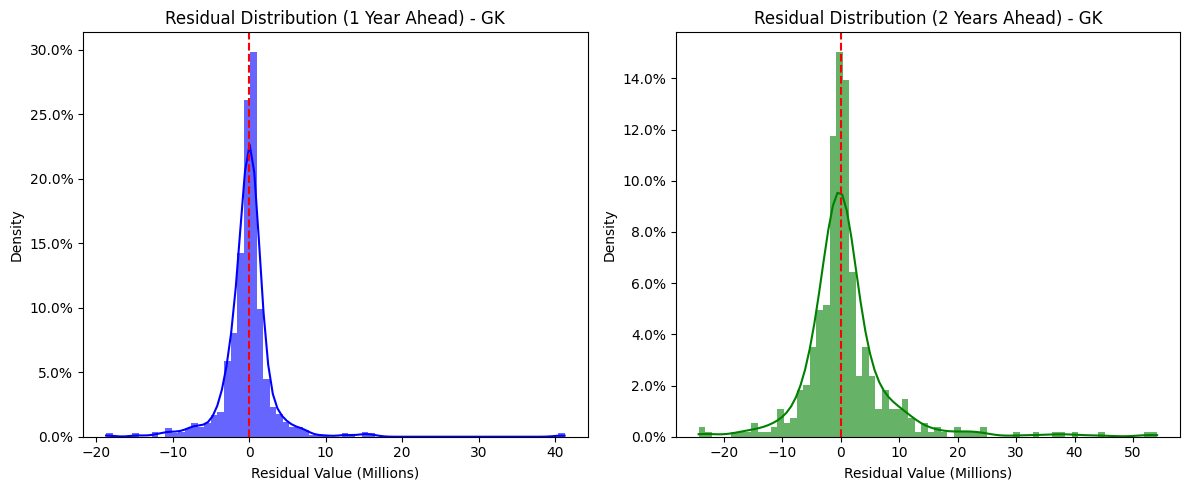

Statistics for GK - 1 Year Ahead:
Mean: -0.16
Median: -0.00
Q1: -1.18
Q3: 0.72


Statistics for GK - 2 Years Ahead:
Mean: 0.96
Median: -0.12
Q1: -1.91
Q3: 2.07


Creating side-by-side histogram for position CB


/var/folders/6_/dhlq5ftj4c76n7p9cz2cjkyw0000gn/T/ipykernel_30346/1350757295.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([f'{round(label * 100, 1)}%' for label in y_labels])
/var/folders/6_/dhlq5ftj4c76n7p9cz2cjkyw0000gn/T/ipykernel_30346/1350757295.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([f'{round(label * 100, 1)}%' for label in y_labels])


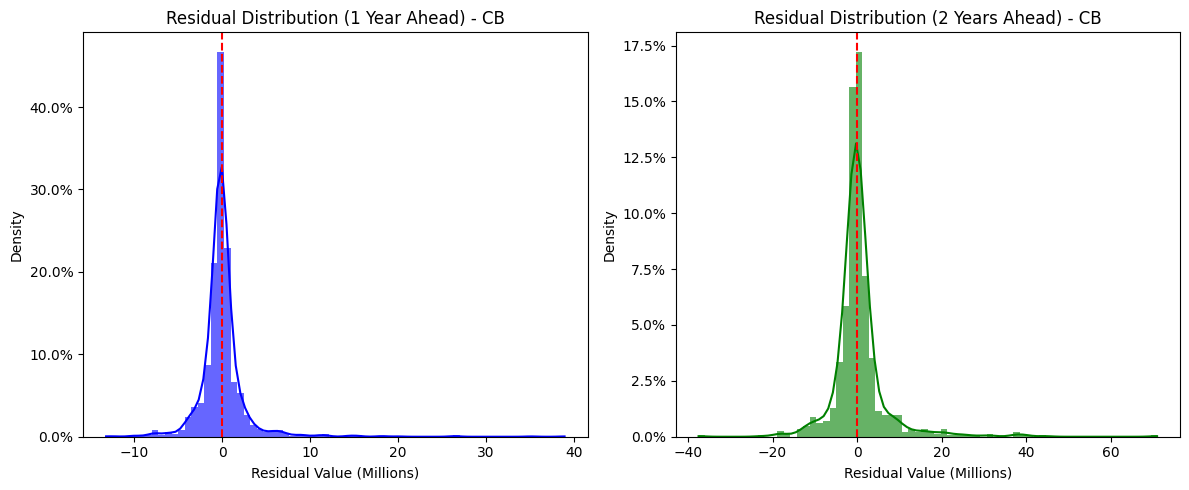

Statistics for CB - 1 Year Ahead:
Mean: -0.01
Median: -0.19
Q1: -0.79
Q3: 0.43


Statistics for CB - 2 Years Ahead:
Mean: 0.51
Median: -0.10
Q1: -1.61
Q3: 1.46


Creating side-by-side histogram for position RB LB


/var/folders/6_/dhlq5ftj4c76n7p9cz2cjkyw0000gn/T/ipykernel_30346/1350757295.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([f'{round(label * 100, 1)}%' for label in y_labels])
/var/folders/6_/dhlq5ftj4c76n7p9cz2cjkyw0000gn/T/ipykernel_30346/1350757295.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([f'{round(label * 100, 1)}%' for label in y_labels])


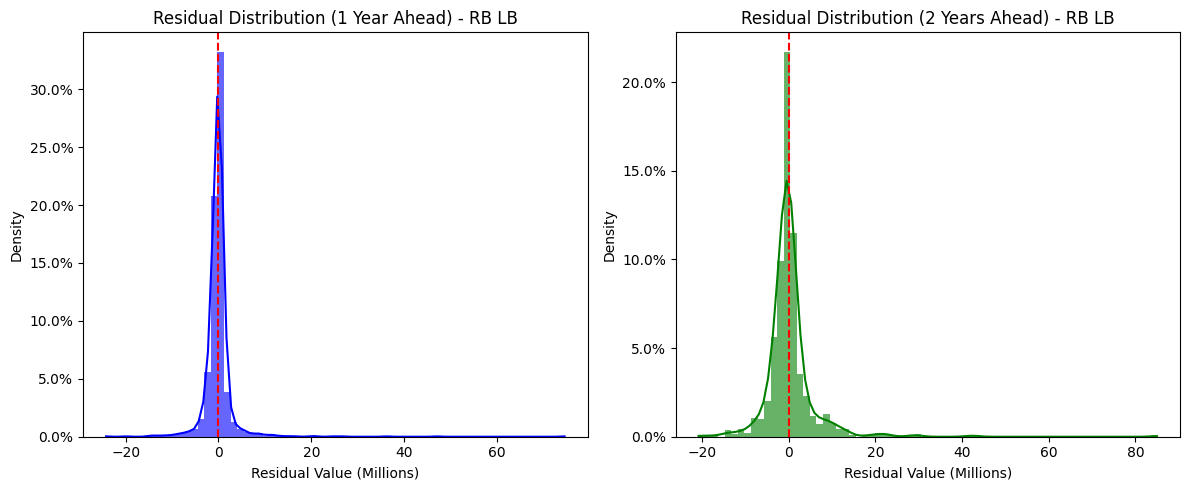

Statistics for RB LB - 1 Year Ahead:
Mean: -0.06
Median: -0.06
Q1: -0.81
Q3: 0.44


Statistics for RB LB - 2 Years Ahead:
Mean: 0.26
Median: -0.25
Q1: -1.76
Q3: 1.10


Creating side-by-side histogram for position DEFENSIVE MID


/var/folders/6_/dhlq5ftj4c76n7p9cz2cjkyw0000gn/T/ipykernel_30346/1350757295.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([f'{round(label * 100, 1)}%' for label in y_labels])
/var/folders/6_/dhlq5ftj4c76n7p9cz2cjkyw0000gn/T/ipykernel_30346/1350757295.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([f'{round(label * 100, 1)}%' for label in y_labels])


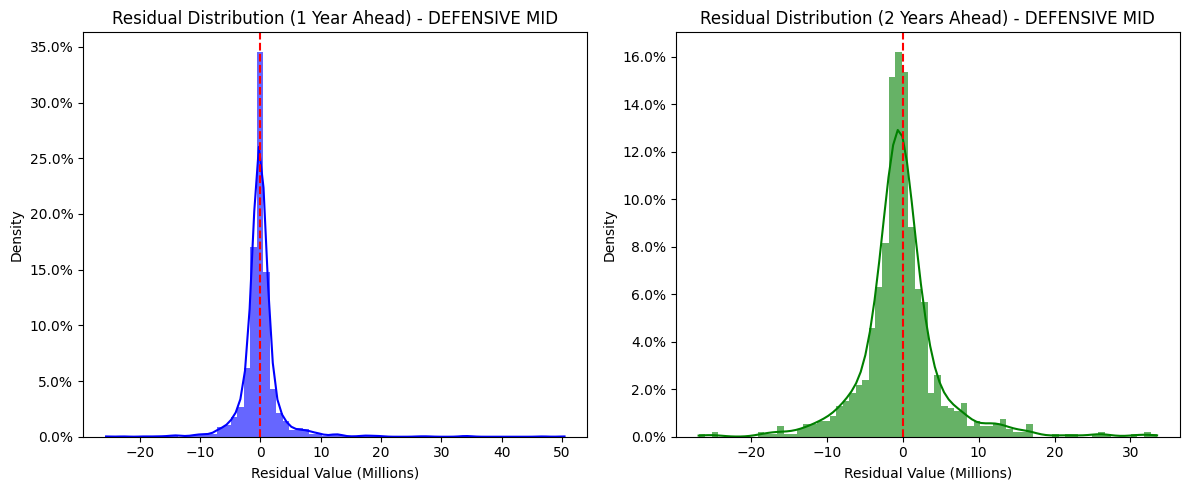

Statistics for DEFENSIVE MID - 1 Year Ahead:
Mean: -0.01
Median: -0.18
Q1: -0.96
Q3: 0.62


Statistics for DEFENSIVE MID - 2 Years Ahead:
Mean: -0.24
Median: -0.50
Q1: -2.38
Q3: 1.37


Creating side-by-side histogram for position ATTACKING MID


/var/folders/6_/dhlq5ftj4c76n7p9cz2cjkyw0000gn/T/ipykernel_30346/1350757295.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([f'{round(label * 100, 1)}%' for label in y_labels])
/var/folders/6_/dhlq5ftj4c76n7p9cz2cjkyw0000gn/T/ipykernel_30346/1350757295.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([f'{round(label * 100, 1)}%' for label in y_labels])


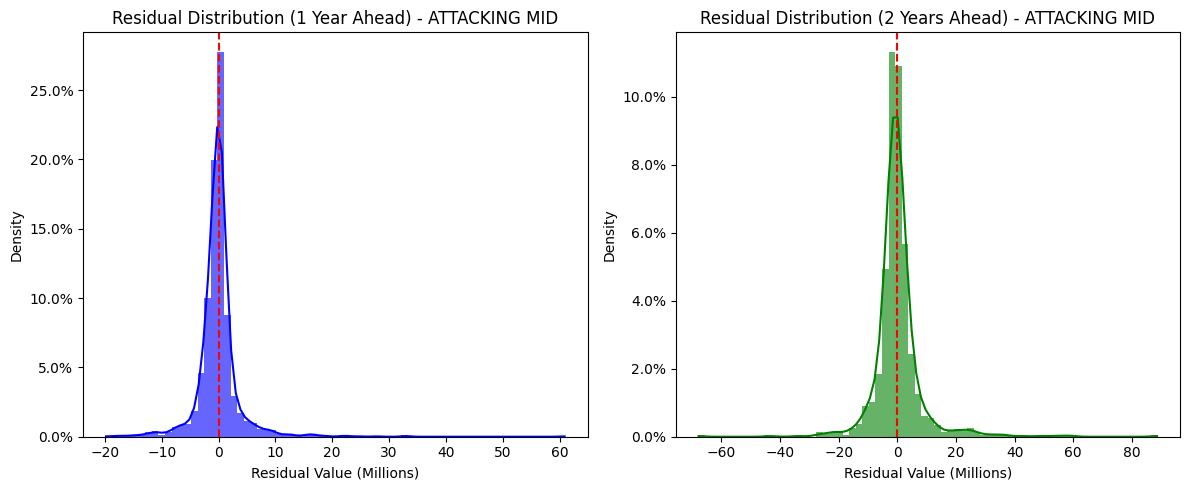

Statistics for ATTACKING MID - 1 Year Ahead:
Mean: -0.03
Median: -0.08
Q1: -1.25
Q3: 0.78


Statistics for ATTACKING MID - 2 Years Ahead:
Mean: 0.12
Median: -0.63
Q1: -2.65
Q3: 1.75


Creating side-by-side histogram for position STRIKER


/var/folders/6_/dhlq5ftj4c76n7p9cz2cjkyw0000gn/T/ipykernel_30346/1350757295.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([f'{round(label * 100, 1)}%' for label in y_labels])
/var/folders/6_/dhlq5ftj4c76n7p9cz2cjkyw0000gn/T/ipykernel_30346/1350757295.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([f'{round(label * 100, 1)}%' for label in y_labels])


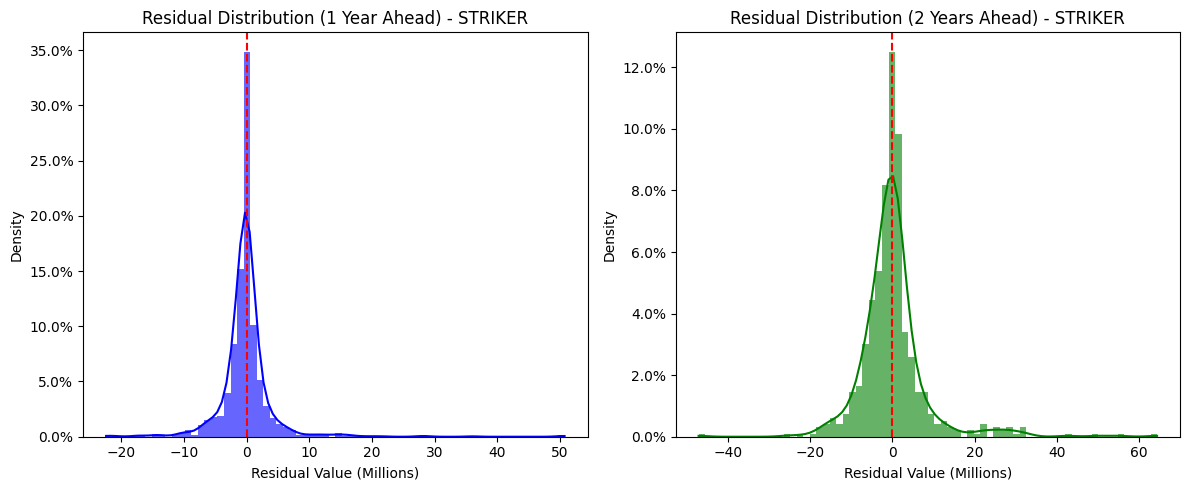

Statistics for STRIKER - 1 Year Ahead:
Mean: -0.13
Median: -0.15
Q1: -1.29
Q3: 0.60


Statistics for STRIKER - 2 Years Ahead:
Mean: 0.05
Median: -0.30
Q1: -3.35
Q3: 1.77




In [25]:

def plot_side_by_side(y_pred_1, y_test_1, y_pred_2, y_test_2, position):
    """
    This function plots the residual distributions for 1 year and 2 years ahead side by side,
    and includes additional statistics like mean, median, Q1, and Q3 below the graphs.
    """
    # Calculate residuals
    residuals_1 = np.array(y_test_1) - np.array(y_pred_1)
    residuals_2 = np.array(y_test_2) - np.array(y_pred_2)

    # Create KDE for both residuals
    kde_1 = gaussian_kde(residuals_1)
    kde_2 = gaussian_kde(residuals_2)

    # Create two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # First plot: 1 year ahead
    axes[0].hist(residuals_1, bins=70, density=True, color='blue', alpha=0.6, label='Residuals 1 year')
    x_vals = np.linspace(min(residuals_1), max(residuals_1), 100)
    axes[0].plot(x_vals, kde_1(x_vals), color='blue', label='KDE 1 year')
    axes[0].set_title(f'Residual Distribution (1 Year Ahead) - {position}')
    axes[0].set_xlabel('Residual Value (Millions)')
    axes[0].set_ylabel('Density')
    axes[0].axvline(0, color='red', linestyle='--')  # Vertical line at the center
    # Convert Y-axis to percentage scale
    y_labels = axes[0].get_yticks()
    axes[0].set_yticklabels([f'{round(label * 100, 1)}%' for label in y_labels])

    # Second plot: 2 years ahead
    axes[1].hist(residuals_2, bins=70, density=True, color='green', alpha=0.6, label='Residuals 2 years')
    x_vals = np.linspace(min(residuals_2), max(residuals_2), 100)
    axes[1].plot(x_vals, kde_2(x_vals), color='green', label='KDE 2 years')
    axes[1].set_title(f'Residual Distribution (2 Years Ahead) - {position}')
    axes[1].set_xlabel('Residual Value (Millions)')
    axes[1].set_ylabel('Density')
    axes[1].axvline(0, color='red', linestyle='--')  # Vertical line at the center
    # Convert Y-axis to percentage scale
    y_labels = axes[1].get_yticks()
    axes[1].set_yticklabels([f'{round(label * 100, 1)}%' for label in y_labels])
    
    
    
    plt.tight_layout()
    plt.show()

    # Calculate and print statistics for 1 year and 2 years
    mean_1, median_1, q1_1, q3_1 = np.mean(residuals_1), np.median(residuals_1), np.percentile(residuals_1, 25), np.percentile(residuals_1, 75)
    mean_2, median_2, q1_2, q3_2 = np.mean(residuals_2), np.median(residuals_2), np.percentile(residuals_2, 25), np.percentile(residuals_2, 75)

    print(f"Statistics for {position} - 1 Year Ahead:")
    print(f"Mean: {mean_1:.2f}")
    print(f"Median: {median_1:.2f}")
    print(f"Q1: {q1_1:.2f}")
    print(f"Q3: {q3_1:.2f}")
    print("\n")

    print(f"Statistics for {position} - 2 Years Ahead:")
    print(f"Mean: {mean_2:.2f}")
    print(f"Median: {median_2:.2f}")
    print(f"Q1: {q1_2:.2f}")
    print(f"Q3: {q3_2:.2f}")
    print("\n")
    
num_features = 9
# Use the function to display the graphs side by side
for i, (result_for_position_1, result_for_position_2) in enumerate(zip(Result_1_year, Result_2_year)):
    print(f'Creating side-by-side histogram for position {pos_list[i+1]}')
    y_pred_1 = result_for_position_1[num_features]['y_pred']
    y_test_1 = result_for_position_1[num_features]['y_test']
    y_pred_2 = result_for_position_2[num_features]['y_pred']
    y_test_2 = result_for_position_2[num_features]['y_test']
    
    # Display the two graphs side by side for each position and print the statistics below
    plot_side_by_side(y_pred_1, y_test_1, y_pred_2, y_test_2, pos_list[i+1])


In [26]:
len(full_joined_df_copy.columns)

286

# Lasso Regression

In [27]:
def LassoRegressionFunc(group_df, target_col, alpha=0.1, max_iter=10000):
    # Define features (X) and target variable (y)
    X = group_df.drop([target_col], axis=1)
    y = group_df[target_col]

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Create the model and fit it to the data (including all features initially)
    model = Lasso(alpha=alpha, max_iter=max_iter)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    final_r2 = r2_score(y_test, y_pred)

    # Convert to millions for convenience
    y_pred_millions = y_pred / 1000000
    y_test_millions = y_test / 1000000
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test_millions, y_pred_millions)

    # Print coefficients of all selected features
    coefficients = model.coef_
    
    # Extract selected features (where coefficient is not zero)
    selected_feature_names = X.columns[coefficients != 0].tolist()

    return model, final_r2, mse, selected_feature_names, coefficients


In [28]:
# pos_list = ['','GK', 'CB', 'RB', 'DEFENCIVE MID', 'ATTACKING MID', 'STRIKER']
# value_eur_list = ['value_eur_1_year', 'value_eur_2_year']

# existing_columns = [col for col in feature_list + ['value_eur_1_year', 'value_eur_2_year'] if col in full_joined_df_copy.columns]

# R2_list_1_year_lasso = []
# R2_list_2_year_lasso = []
# coefficient_1_year = []
# coefficient_2_year = []
# for i in range(1,7):
#     print(f"Position:{pos_list[i]}")
#     print("predict 1 year ahead:\n ")
#     group_df = full_joined_df_copy[(full_joined_df_copy['position'] == i) ]
#     group_df = group_df[existing_columns].drop('value_eur_2_year', axis = 1)
#     group_df = group_df[group_df['value_eur_1_year']>0]
#     model, R2_score, mse, selected_features, coef = LassoRegressionFunc(group_df, 'value_eur_1_year')
#     coefficient_1_year.append(coef)
#     print(f'The R^2 for {pos_list[i]} is {R2_score}\n\nselected features are:\n{selected_features}\nThe MSE is {mse}')


# ########################
#     print("\npredict 2 year ahead:\n")

#     group_df = full_joined_df_copy[(full_joined_df_copy['position'] == i) ]
#     group_df = group_df[existing_columns].drop('value_eur_1_year', axis = 1)
#     group_df = group_df[group_df['value_eur_2_year']>0]
#     group_df = group_df[group_df['club_rank'] != 6]

    
#     model, R2_score, mse, selected_features, coef = LassoRegressionFunc (group_df, 'value_eur_2_year')

#     coefficient_2_year.append(coef)
#     print(f'The R^2 for {pos_list[i]} is {R2_score}\n\nselected features are:\n{selected_features}\nThe MSE is {mse}\n')
#     print('-' * 110)
#     R2_list_2_year_lasso.append(R2_score)


# Define columns you want to include in your model
existing_columns = [col for col in feature_list + ['value_eur_1_year', 'value_eur_2_year'] if col in full_joined_df_copy.columns]
# Initialize a list to store the results
results_lasso = []

# Iterate over positions
for i in range(1, 7):
    print(f"Position: {pos_list[i]}")
    
    # Predict 1 year ahead
    print("Predicting 1 year ahead...\n")
    group_df = full_joined_df_copy[(full_joined_df_copy['position'] == i)]
    group_df = group_df[existing_columns].drop('value_eur_2_year', axis=1)
    group_df = group_df[group_df['value_eur_1_year'] > 0]

    model, r2_score_1_year, mse_1_year, selected_features_1_year, coef_1_year = LassoRegressionFunc(group_df, 'value_eur_1_year')
    
    # Store the result for 1 year ahead
    results_lasso.append({
        'Position': pos_list[i],
        'Years Ahead': 1,
        'R²': r2_score_1_year,
        'MSE': mse_1_year,
        'Selected Features': ', '.join(selected_features_1_year),  # Flatten selected features into a comma-separated string
        'Coefficients': ', '.join(map(str, coef_1_year))  # Flatten coefficients into a comma-separated string
    })

    # Predict 2 years ahead
    print("\nPredicting 2 years ahead...\n")
    group_df = full_joined_df_copy[(full_joined_df_copy['position'] == i)]
    group_df = group_df[existing_columns].drop('value_eur_1_year', axis=1)
    group_df = group_df[group_df['value_eur_2_year'] > 0]
    group_df = group_df[group_df['club_rank'] != 6]

    model, r2_score_2_year, mse_2_year, selected_features_2_year, coef_2_year = LassoRegressionFunc(group_df, 'value_eur_2_year')
    
    # Store the result for 2 years ahead
    results_lasso.append({
        'Position': pos_list[i],
        'Years Ahead': 2,
        'R²': r2_score_2_year,
        'MSE': mse_2_year,
        'Selected Features': ', '.join(selected_features_2_year),  # Flatten selected features
        'Coefficients': ', '.join(map(str, coef_2_year))  # Flatten coefficients
    })

# Convert the results into a DataFrame
results_lasso_df = pd.DataFrame(results_lasso)

Position: GK
Predicting 1 year ahead...



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.593e+16, tolerance: 2.892e+13
  model = cd_fast.enet_coordinate_descent(



Predicting 2 years ahead...



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.623e+16, tolerance: 2.372e+13
  model = cd_fast.enet_coordinate_descent(


Position: CB
Predicting 1 year ahead...



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.600e+16, tolerance: 3.554e+13
  model = cd_fast.enet_coordinate_descent(



Predicting 2 years ahead...



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.877e+16, tolerance: 3.188e+13
  model = cd_fast.enet_coordinate_descent(


Position: RB LB
Predicting 1 year ahead...



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e+16, tolerance: 2.270e+13
  model = cd_fast.enet_coordinate_descent(



Predicting 2 years ahead...



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.249e+16, tolerance: 1.937e+13
  model = cd_fast.enet_coordinate_descent(


Position: DEFENSIVE MID
Predicting 1 year ahead...



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.556e+16, tolerance: 5.893e+13
  model = cd_fast.enet_coordinate_descent(



Predicting 2 years ahead...



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.024e+16, tolerance: 6.093e+13
  model = cd_fast.enet_coordinate_descent(


Position: ATTACKING MID
Predicting 1 year ahead...



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.587e+16, tolerance: 8.626e+13
  model = cd_fast.enet_coordinate_descent(



Predicting 2 years ahead...



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.711e+16, tolerance: 7.823e+13
  model = cd_fast.enet_coordinate_descent(


Position: STRIKER
Predicting 1 year ahead...



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.424e+16, tolerance: 5.886e+13
  model = cd_fast.enet_coordinate_descent(



Predicting 2 years ahead...



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.421e+16, tolerance: 5.025e+13
  model = cd_fast.enet_coordinate_descent(


In [29]:
results_lasso_df[['Position', 'Years Ahead', 'R²', 'MSE', 'Selected Features']]

,Position,Years Ahead,R²,MSE,Selected Features
0,GK,1,0.871757,12.465100,"age_attacking_crossing ** 2, age_attacking_short_passing, age_attacking_short_passing ** 2, age_club_rank, age_club_rank ** 2, age_defence, age_defence ** 2, age_defending_sliding_tackle, age_defending_sliding_tackle ** 2, age_international_reputation, age_international_reputation ** 2, age_movement_agility ** 2, age_movement_reactions, age_movement_reactions ** 2, age_potential ** 2, age_power_jumping ** 2, age_power_long_shots, age_power_long_shots ** 2, age_power_stamina, age_skill_ball_control, age_skill_ball_control ** 2, age_skill_dribbling ** 2, age_skill_long_passing, age_skill_long_passing ** 2, club_contract_valid_until_year, club_contract_valid_until_year ** 2, club_rank, club_rank ** 2, fifa_age ** 2, fifa_version ** 2, gk, gk ** 2, height_cm ** 2, international_reputation, international_reputation ** 2, lw ** 2, movement_agility ** 2, movement_reactions ** 2, overall ** 2, player_tags ** 2, potential, release_clause_eur, skill_ball_control, value_eur, value_eur ** 2, wage_eur, year_contract ** 2"
1,GK,2,0.729601,65.761602,"age_attacking_crossing ** 2, age_attacking_short_passing, age_attacking_short_passing ** 2, age_club_rank, age_club_rank ** 2, age_defence, age_defence ** 2, age_defending_sliding_tackle, age_defending_sliding_tackle ** 2, age_international_reputation, age_international_reputation ** 2, age_movement_agility ** 2, age_movement_reactions, age_movement_reactions ** 2, age_potential ** 2, age_power_jumping ** 2, age_power_long_shots, age_power_long_shots ** 2, age_power_stamina, age_skill_ball_control, age_skill_ball_control ** 2, age_skill_dribbling ** 2, age_skill_long_passing, age_skill_long_passing ** 2, club_contract_valid_until_year, club_contract_valid_until_year ** 2, club_rank, club_rank ** 2, fifa_age ** 2, fifa_version ** 2, gk, gk ** 2, height_cm ** 2, international_reputation, international_reputation ** 2, lw ** 2, movement_agility ** 2, movement_reactions ** 2, overall ** 2, player_tags ** 2, potential, release_clause_eur, skill_ball_control, value_eur, value_eur ** 2, wage_eur, year_contract ** 2"
2,CB,1,0.877884,8.335399,"age_attacking_crossing ** 2, age_attacking_short_passing, age_attacking_short_passing ** 2, age_club_rank, age_club_rank ** 2, age_defence, age_defence ** 2, age_defending ** 2, age_defending_sliding_tackle, age_defending_sliding_tackle ** 2, age_dribbling, age_dribbling ** 2, age_international_reputation, age_international_reputation ** 2, age_movement_agility ** 2, age_movement_reactions, age_movement_reactions ** 2, age_passing, age_passing ** 2, age_potential ** 2, age_power_jumping ** 2, age_power_long_shots, age_power_long_shots ** 2, age_power_stamina, age_skill_ball_control, age_skill_ball_control ** 2, age_skill_dribbling ** 2, age_skill_long_passing, age_skill_long_passing ** 2, club_contract_valid_until_year, club_contract_valid_until_year ** 2, club_rank, club_rank ** 2, defending, fifa_age ** 2, fifa_version ** 2, gk, gk ** 2, height_cm ** 2, international_reputation, international_reputation ** 2, lw ** 2, movement_agility ** 2, movement_reactions ** 2, overall ** 2, player_tags ** 2, potential, release_clause_eur, skill_ball_control, value_eur, value_eur ** 2, wage_eur, year_contract ** 2"
3,CB,2,0.645426,45.430338,"age_attacking_crossing ** 2, age_attacking_short_passing, age_attacking_short_passing ** 2, age_club_rank, age_club_rank ** 2, age_defence, age_defence ** 2, age_defending ** 2, age_defending_sliding_tackle, age_defending_sliding_tackle ** 2, age_dribbling, age_dribbling ** 2, age_international_reputation, age_international_reputation ** 2, age_movement_agility ** 2, age_movement_reactions, age_movement_reactions ** 2, age_passing, age_passing ** 2, age_potential ** 2, age_power_jumping ** 2, age_power_long_shots, age_power_long_shots ** 2, age_power_stamina, age_skill_ball_control, age_skill_ball_control ** 2, age_skill_dribbling ** 2, age_skill_long_passing, age_s

# Random Forest

In [30]:
def SimpleRandomForest(group_df, target_col='value_eur', n_estimators=500, max_depth=6):
    # Define features (X) and target variable (y)
    X = group_df.drop([target_col], axis=1)
    y = group_df[target_col]

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Create the model
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)

    # Fit the model with tqdm for progress tracking
    for _ in tqdm(range(1), desc="Training Progress"):
        model.fit(X_train, y_train)

    # Make predictions and check performance
    y_pred = model.predict(X_test)
    y_pred = y_pred / 1000000  # Convert to millions for convenience
    y_test = y_test / 1000000  # Convert to millions for convenience

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Get feature importances and selected feature names
    feature_importances = model.feature_importances_
    selected_feature_names = X.columns[feature_importances > 0].tolist()

    print(f'R^2: {r2:.4f}, MSE: {mse:.4f}')
    
    return model, selected_feature_names, r2, mse

In [31]:
# Initialize lists to store the results
results = []

# Iterate over positions
for i in range(1, 7):

    # Predict 1 year ahead
    print("Predicting 1 year ahead: \n")
    group_df = full_joined_df_copy[(full_joined_df_copy['position'] == i)]
    group_df = group_df[existing_columns].drop('value_eur_2_year', axis=1)
    group_df = group_df[group_df['value_eur_1_year'] > 0]

    model, selected_features, r2_score_1_year, mse_1_year = SimpleRandomForest(group_df, 'value_eur_1_year')
    print(f"Selected features (1 year ahead): {selected_features}\n")

    # Store the result for 1 year ahead
    results.append({
        'Position': pos_list[i],
        'Years Ahead': 1,
        'R²': r2_score_1_year,
        'MSE': mse_1_year,
        'Selected Features': selected_features
    })

    # Predict 2 years ahead
    print("\nPredicting 2 years ahead: \n")
    group_df = full_joined_df_copy[(full_joined_df_copy['position'] == i)]
    group_df = group_df[existing_columns].drop('value_eur_1_year', axis=1)
    group_df = group_df[group_df['value_eur_2_year'] > 0]
    group_df = group_df[group_df['club_rank'] != 6]

    model, selected_features, r2_score_2_year, mse_2_year = SimpleRandomForest(group_df, 'value_eur_2_year')


    # Store the result for 2 years ahead
    results.append({
        'Position': pos_list[i],
        'Years Ahead': 2,
        'R²': r2_score_2_year,
        'MSE': mse_2_year,
        'Selected Features': selected_features
    })

# Convert the results list into a DataFrame
results_df = pd.DataFrame(results)


Predicting 1 year ahead: 



Training Progress: 100%|██████████████████████████| 1/1 [00:03<00:00,  3.04s/it]


R^2: 0.8827, MSE: 11.4033
Selected features (1 year ahead): ['age_attacking_crossing ** 2', 'age_attacking_short_passing', 'age_attacking_short_passing ** 2', 'age_club_rank', 'age_club_rank ** 2', 'age_defence', 'age_defence ** 2', 'age_defending_sliding_tackle', 'age_defending_sliding_tackle ** 2', 'age_international_reputation', 'age_international_reputation ** 2', 'age_movement_agility ** 2', 'age_movement_reactions', 'age_movement_reactions ** 2', 'age_potential ** 2', 'age_power_jumping ** 2', 'age_power_long_shots', 'age_power_long_shots ** 2', 'age_power_stamina', 'age_skill_ball_control', 'age_skill_ball_control ** 2', 'age_skill_dribbling ** 2', 'age_skill_long_passing', 'age_skill_long_passing ** 2', 'club_contract_valid_until_year', 'club_contract_valid_until_year ** 2', 'club_rank', 'club_rank ** 2', 'fifa_age ** 2', 'fifa_version ** 2', 'gk', 'gk ** 2', 'height_cm ** 2', 'international_reputation', 'international_reputation ** 2', 'lw ** 2', 'movement_agility ** 2', 'move

Training Progress: 100%|██████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


R^2: 0.6807, MSE: 77.6517
Predicting 1 year ahead: 



Training Progress: 100%|██████████████████████████| 1/1 [00:06<00:00,  6.63s/it]


R^2: 0.8545, MSE: 9.9317
Selected features (1 year ahead): ['age_attacking_crossing ** 2', 'age_attacking_short_passing', 'age_attacking_short_passing ** 2', 'age_club_rank', 'age_club_rank ** 2', 'age_defence', 'age_defence ** 2', 'age_defending ** 2', 'age_defending_sliding_tackle', 'age_defending_sliding_tackle ** 2', 'age_dribbling', 'age_dribbling ** 2', 'age_international_reputation', 'age_international_reputation ** 2', 'age_movement_agility ** 2', 'age_movement_reactions', 'age_movement_reactions ** 2', 'age_passing', 'age_passing ** 2', 'age_potential ** 2', 'age_power_jumping ** 2', 'age_power_long_shots', 'age_power_long_shots ** 2', 'age_power_stamina', 'age_skill_ball_control', 'age_skill_ball_control ** 2', 'age_skill_dribbling ** 2', 'age_skill_long_passing', 'age_skill_long_passing ** 2', 'club_contract_valid_until_year', 'club_contract_valid_until_year ** 2', 'club_rank', 'club_rank ** 2', 'defending', 'fifa_age ** 2', 'fifa_version ** 2', 'gk', 'gk ** 2', 'height_cm *

Training Progress: 100%|██████████████████████████| 1/1 [00:03<00:00,  3.44s/it]


R^2: 0.6546, MSE: 44.2556
Predicting 1 year ahead: 



Training Progress: 100%|██████████████████████████| 1/1 [00:05<00:00,  5.18s/it]


R^2: 0.7487, MSE: 11.8050
Selected features (1 year ahead): ['age_attacking_crossing ** 2', 'age_attacking_short_passing', 'age_attacking_short_passing ** 2', 'age_club_rank', 'age_club_rank ** 2', 'age_defence', 'age_defence ** 2', 'age_defending ** 2', 'age_defending_sliding_tackle', 'age_defending_sliding_tackle ** 2', 'age_dribbling', 'age_dribbling ** 2', 'age_international_reputation', 'age_international_reputation ** 2', 'age_movement_agility ** 2', 'age_movement_reactions', 'age_movement_reactions ** 2', 'age_passing', 'age_passing ** 2', 'age_potential ** 2', 'age_power_jumping ** 2', 'age_power_long_shots', 'age_power_long_shots ** 2', 'age_power_stamina', 'age_skill_ball_control', 'age_skill_ball_control ** 2', 'age_skill_dribbling ** 2', 'age_skill_long_passing', 'age_skill_long_passing ** 2', 'club_contract_valid_until_year', 'club_contract_valid_until_year ** 2', 'club_rank', 'club_rank ** 2', 'defending', 'fifa_age ** 2', 'fifa_version ** 2', 'gk', 'gk ** 2', 'height_cm 

Training Progress: 100%|██████████████████████████| 1/1 [00:02<00:00,  2.85s/it]


R^2: 0.6760, MSE: 34.4613
Predicting 1 year ahead: 



Training Progress: 100%|██████████████████████████| 1/1 [00:08<00:00,  8.58s/it]


R^2: 0.8833, MSE: 14.5272
Selected features (1 year ahead): ['age_attacking_crossing ** 2', 'age_attacking_short_passing', 'age_attacking_short_passing ** 2', 'age_club_rank', 'age_club_rank ** 2', 'age_defence', 'age_defence ** 2', 'age_defending ** 2', 'age_defending_sliding_tackle', 'age_defending_sliding_tackle ** 2', 'age_dribbling', 'age_dribbling ** 2', 'age_international_reputation', 'age_international_reputation ** 2', 'age_movement_agility ** 2', 'age_movement_reactions', 'age_movement_reactions ** 2', 'age_passing', 'age_passing ** 2', 'age_potential ** 2', 'age_power_jumping ** 2', 'age_power_long_shots', 'age_power_long_shots ** 2', 'age_power_stamina', 'age_skill_ball_control', 'age_skill_ball_control ** 2', 'age_skill_dribbling ** 2', 'age_skill_long_passing', 'age_skill_long_passing ** 2', 'club_contract_valid_until_year', 'club_contract_valid_until_year ** 2', 'club_rank', 'club_rank ** 2', 'defending', 'fifa_age ** 2', 'fifa_version ** 2', 'gk', 'gk ** 2', 'height_cm 

Training Progress: 100%|██████████████████████████| 1/1 [00:05<00:00,  5.29s/it]


R^2: 0.7973, MSE: 32.8273
Predicting 1 year ahead: 



Training Progress: 100%|██████████████████████████| 1/1 [00:06<00:00,  6.92s/it]


R^2: 0.8774, MSE: 16.6745
Selected features (1 year ahead): ['age_attacking_crossing ** 2', 'age_attacking_short_passing', 'age_attacking_short_passing ** 2', 'age_club_rank', 'age_club_rank ** 2', 'age_defence', 'age_defence ** 2', 'age_defending ** 2', 'age_defending_sliding_tackle', 'age_defending_sliding_tackle ** 2', 'age_dribbling', 'age_dribbling ** 2', 'age_international_reputation', 'age_international_reputation ** 2', 'age_movement_agility ** 2', 'age_movement_reactions', 'age_movement_reactions ** 2', 'age_passing', 'age_passing ** 2', 'age_potential ** 2', 'age_power_jumping ** 2', 'age_power_long_shots', 'age_power_long_shots ** 2', 'age_power_stamina', 'age_skill_ball_control', 'age_skill_ball_control ** 2', 'age_skill_dribbling ** 2', 'age_skill_long_passing', 'age_skill_long_passing ** 2', 'club_contract_valid_until_year', 'club_contract_valid_until_year ** 2', 'club_rank', 'club_rank ** 2', 'defending', 'fifa_age ** 2', 'fifa_version ** 2', 'gk', 'gk ** 2', 'height_cm 

Training Progress: 100%|██████████████████████████| 1/1 [00:03<00:00,  3.44s/it]


R^2: 0.7301, MSE: 66.5553
Predicting 1 year ahead: 



Training Progress: 100%|██████████████████████████| 1/1 [00:03<00:00,  3.56s/it]


R^2: 0.8370, MSE: 21.2938
Selected features (1 year ahead): ['age_attacking_crossing ** 2', 'age_attacking_short_passing', 'age_attacking_short_passing ** 2', 'age_club_rank', 'age_club_rank ** 2', 'age_defence', 'age_defence ** 2', 'age_defending ** 2', 'age_defending_sliding_tackle', 'age_defending_sliding_tackle ** 2', 'age_dribbling', 'age_dribbling ** 2', 'age_international_reputation', 'age_international_reputation ** 2', 'age_movement_agility ** 2', 'age_movement_reactions', 'age_movement_reactions ** 2', 'age_passing', 'age_passing ** 2', 'age_potential ** 2', 'age_power_jumping ** 2', 'age_power_long_shots', 'age_power_long_shots ** 2', 'age_power_stamina', 'age_skill_ball_control', 'age_skill_ball_control ** 2', 'age_skill_dribbling ** 2', 'age_skill_long_passing', 'age_skill_long_passing ** 2', 'club_contract_valid_until_year', 'club_contract_valid_until_year ** 2', 'club_rank', 'club_rank ** 2', 'defending', 'fifa_age ** 2', 'fifa_version ** 2', 'gk', 'gk ** 2', 'height_cm 

Training Progress: 100%|██████████████████████████| 1/1 [00:02<00:00,  2.38s/it]

R^2: 0.7625, MSE: 75.9514


In [32]:
results_df

,Position,Years Ahead,R²,MSE,Selected Features
0,GK,1,0.882681,11.403280,"[age_attacking_crossing ** 2, age_attacking_short_passing, age_attacking_short_passing ** 2, age_club_rank, age_club_rank ** 2, age_defence, age_defence ** 2, age_defending_sliding_tackle, age_defending_sliding_tackle ** 2, age_international_reputation, age_international_reputation ** 2, age_movement_agility ** 2, age_movement_reactions, age_movement_reactions ** 2, age_potential ** 2, age_power_jumping ** 2, age_power_long_shots, age_power_long_shots ** 2, age_power_stamina, age_skill_ball_control, age_skill_ball_control ** 2, age_skill_dribbling ** 2, age_skill_long_passing, age_skill_long_passing ** 2, club_contract_valid_until_year, club_contract_valid_until_year ** 2, club_rank, club_rank ** 2, fifa_age ** 2, fifa_version ** 2, gk, gk ** 2, height_cm ** 2, international_reputation, international_reputation ** 2, lw ** 2, movement_agility ** 2, movement_reactions ** 2, overall ** 2, potential, release_clause_eur, skill_ball_control, value_eur, value_eur ** 2, wage_eur, year_contract ** 2]"
1,GK,2,0.680711,77.651715,"[age_attacking_crossing ** 2, age_attacking_short_passing, age_attacking_short_passing ** 2, age_club_rank, age_club_rank ** 2, age_defence, age_defence ** 2, age_defending_sliding_tackle, age_defending_sliding_tackle ** 2, age_international_reputation, age_international_reputation ** 2, age_movement_agility ** 2, age_movement_reactions, age_movement_reactions ** 2, age_potential ** 2, age_power_jumping ** 2, age_power_long_shots, age_power_long_shots ** 2, age_power_stamina, age_skill_ball_control, age_skill_ball_control ** 2, age_skill_dribbling ** 2, age_skill_long_passing, age_skill_long_passing ** 2, club_contract_valid_until_year, club_contract_valid_until_year ** 2, club_rank, club_rank ** 2, fifa_age ** 2, fifa_version ** 2, gk, gk ** 2, height_cm ** 2, international_reputation, international_reputation ** 2, lw ** 2, movement_agility ** 2, movement_reactions ** 2, overall ** 2, potential, release_clause_eur, skill_ball_control, value_eur, value_eur ** 2, wage_eur, year_contract ** 2]"
2,CB,1,0.854498,9.931728,"[age_attacking_crossing ** 2, age_attacking_short_passing, age_attacking_short_passing ** 2, age_club_rank, age_club_rank ** 2, age_defence, age_defence ** 2, age_defending ** 2, age_defending_sliding_tackle, age_defending_sliding_tackle ** 2, age_dribbling, age_dribbling ** 2, age_international_reputation, age_international_reputation ** 2, age_movement_agility ** 2, age_movement_reactions, age_movement_reactions ** 2, age_passing, age_passing ** 2, age_potential ** 2, age_power_jumping ** 2, age_power_long_shots, age_power_long_shots ** 2, age_power_stamina, age_skill_ball_control, age_skill_ball_control ** 2, age_skill_dribbling ** 2, age_skill_long_passing, age_skill_long_passing ** 2, club_contract_valid_until_year, club_contract_valid_until_year ** 2, club_rank, club_rank ** 2, defending, fifa_age ** 2, fifa_version ** 2, gk, gk ** 2, height_cm ** 2, international_reputation, international_reputation ** 2, lw ** 2, movement_agility ** 2, movement_reactions ** 2, overall ** 2, player_tags ** 2, potential, release_clause_eur, skill_ball_control, value_eur, value_eur ** 2, wage_eur, year_contract ** 2]"
3,CB,2,0.654595,44.255602,"[age_attacking_crossing ** 2, age_attacking_short_passing, age_attacking_short_passing ** 2, age_club_rank, age_club_rank ** 2, age_defence, age_defence ** 2, age_defending ** 2, age_defending_sliding_tackle, age_defending_sliding_tackle ** 2, age_dribbling, age_dribbling ** 2, age_international_reputation, age_international_reputation ** 2, age_movement_agility ** 2, age_movement_reactions, age_movement_reactions ** 2, age_passing, age_passing ** 2, age_potential ** 2, age_power_jumping ** 2, age_power_long_shots, age_power_long_shots ** 2, age_power_stamina, age_skill_ball_control, age_skill_ball_control ** 2, age_skill_dribbling ** 2, age_skill_long_passing, age_skill_long_passing ** 2, club_